In [1]:
import os
import yaml
import torch
import torchvision
from tqdm import tqdm

os.chdir('..')
from inference.utils import *
from core.utils import load_or_fail
from train import ControlNetCore, WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Choose your ControlNet

#### Inpainting / Outpainting

In [ ]:
!wget https://huggingface.co/stabilityai/stable-cascade/resolve/main/controlnet/inpainting.safetensors -P models -q --show-progress

In [3]:
config_file = 'configs/inference/controlnet_c_3b_inpainting.yaml'

#### Face Identity (Not available yet)

In [2]:
# config_file = 'configs/inference/controlnet_c_3b_identity.yaml'

#### Canny

In [2]:
!wget https://huggingface.co/stabilityai/stable-cascade/resolve/main/controlnet/canny.safetensors -P models -q --show-progress

canny.safetensors.1 100%[===================>] 207.65M  93.8MB/s    in 2.2s    


In [3]:
config_file = 'configs/inference/controlnet_c_3b_canny.yaml'

#### Super Resolution

In [ ]:
!wget https://huggingface.co/stabilityai/stable-cascade/resolve/main/controlnet/super_resolution.safetensors -P models -q --show-progress

In [3]:
config_file = 'configs/inference/controlnet_c_3b_sr.yaml'

## Load Config & Models

### Load Config

In [4]:
# SETUP STAGE C
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)

core = ControlNetCore(config_dict=loaded_config, device=device, training=False)

# SETUP STAGE B
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core_b = WurstCoreB(config_dict=config_file_b, device=device, training=False)

['model_version', 'effnet_checkpoint_path', 'previewer_checkpoint_path', 'controlnet_blocks', 'controlnet_filter']
['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']


### Load Extras & Models

In [5]:
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.eval().requires_grad_(False)
print("CONTROLNET READY")

extras_b = core_b.setup_extras_pre()
models_b = core_b.setup_models(extras_b, skip_clip=True)
models_b = WurstCoreB.Models(
   **{**models_b.to_dict(), 'tokenizer': models.tokenizer, 'text_model': models.text_model}
)
models_b.generator.eval().requires_grad_(False)
print("STAGE B READY")

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess', 'controlnet_filter']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


['tokenizer', 'text_model', 'generator', 'effnet', 'previewer', 'controlnet']
CONTROLNET READY
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


### Inpainting / Outpainting

**Note**: You are able to define your own masks with the `mask` parameter or for demonstration purposes, use what we do during training to generate masks: use a tiny saliency model to predict the area of "interesting content", like an animal, a person, an object etc. This results in masks that closely mimic how humans actually inpaint, can be calculated extremely fast and with just a few lines of code. You have two parameters to control the masks `threshold` and `outpaint`. The former determines how much area will be masked and `outpaint` would just flip the predicted mask. Just play around with the parameters and you will get a feeling for it (`theshold` should be between 0.0 and 0.4). If you do wish, to load your own masks, just uncomment the `mask` parameter and replace it with your own.

### Canny

**Note**: This here is a typical ControlNet for Canny Edge Detection. You can also use it for doing *sketch-to-image*. You can enable that, by setting `sketch = True` and providing a sketch as the image.

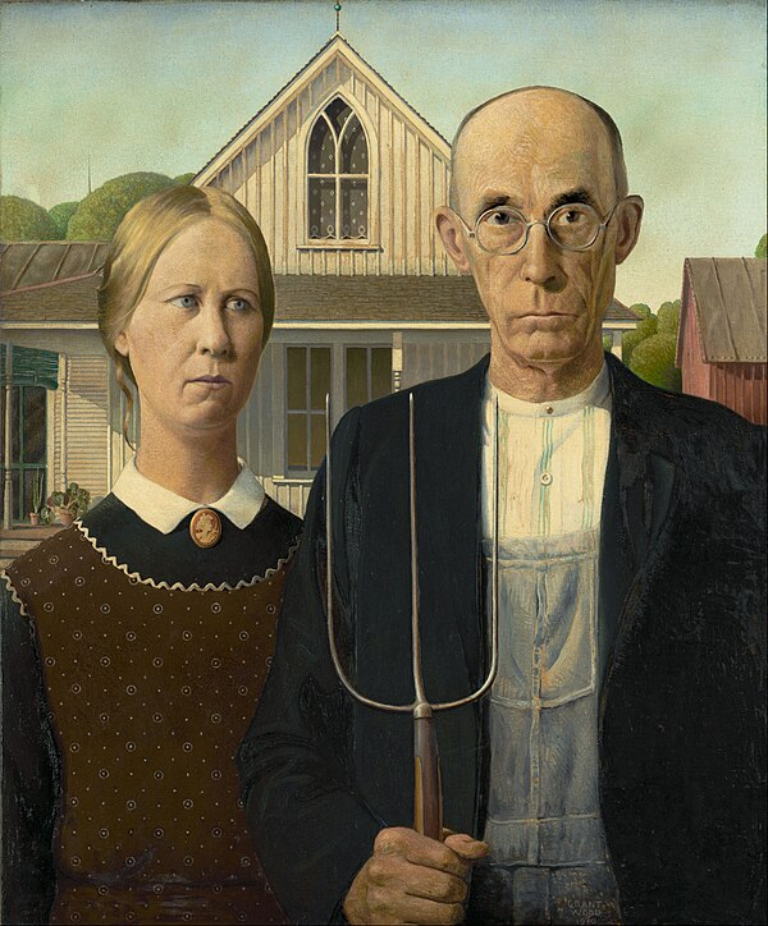

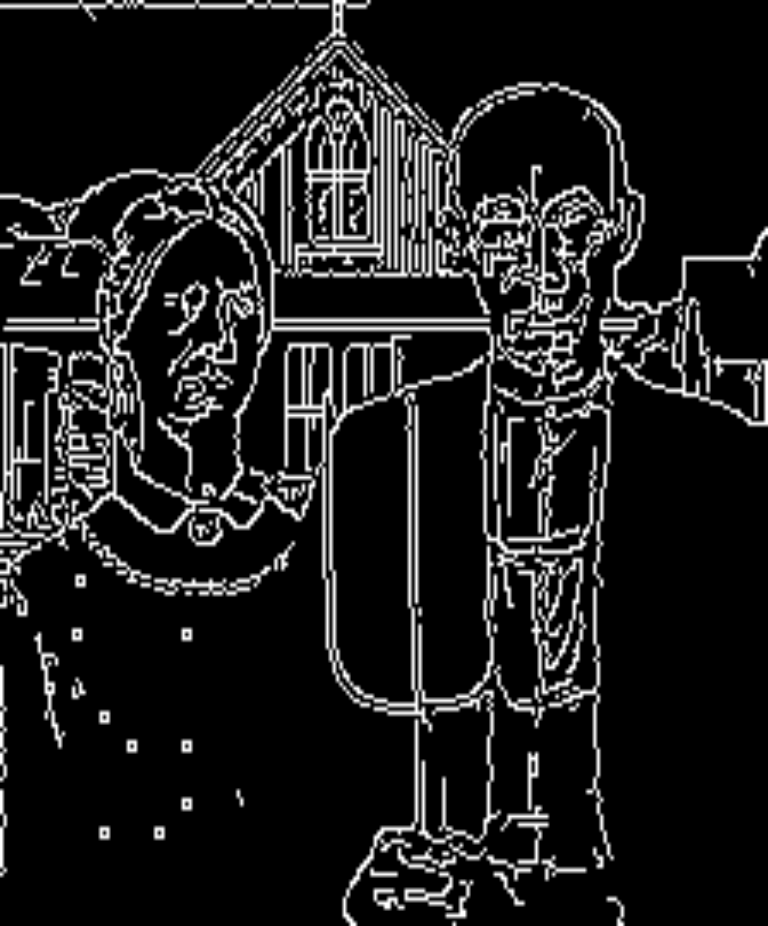

In [28]:
batch_size = 1
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg/600px-Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg"
images = resize_image(download_image(url)).unsqueeze(0).expand(batch_size, -1, -1, -1)
sketch = False

batch = {'images': images}

if sketch:
    cnet_input = 1-images.mean(dim=1, keepdim=True)
else:
    cnet_input = None

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    cnet, cnet_input = core.get_cnet(batch, models, extras, cnet_input=cnet_input)
    cnet_uncond = cnet
    
show_images(batch['images'])
show_images(cnet_input)

### Optional: Compile Stage C and Stage B

**Note**: This will increase speed inference by about 2x, but will initially take a few minutes to compile. Moreover, currently using `torch.compile` only works for a single image resolution, e.g. 1024 x 1024. If you use a different size, it will recompile. See more [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In [ ]:
models = ControlNetCore.Models(
   **{**models.to_dict(), 'generator': torch.compile(models.generator, mode="reduce-overhead", fullgraph=True)}
)

models_b = WurstCoreB.Models(
   **{**models_b.to_dict(), 'generator': torch.compile(models_b.generator, mode="reduce-overhead", fullgraph=True)}
)

## ControlNet Generation

In [39]:
artists = ['Alvar Aalto',
'Slim Aarons',
'Edwin Austin Abbey',
'Gertrude Abercrombie',
'Marina Abramović',
'Tomma Abts',
'Vito Acconci',
'Andreas Achenbach',
'Norman Ackroyd',
'Ansel Adams',
'Arthur Adams',
'Neal Adams',
'Josh Adamski',
'Charles Addams',
'Etel Adnan',
'Mattias Adolfsson',
'Alena Aenami',
'Pieter Aertsen',
'Hilma af Klint',
'N/A Affandi',
'Leonid Afremov',
'Yaacov Agam',
'Eileen Agar',
'Jacques-Laurent Agasse',
'Craigie Aitchison',
'Doug Aitken',
'Ivan Aivazovsky',
'David Aja',
'Sherry Akrami',
'Rashad Alakbarov',
'Anni Albers',
'Josef Albers',
'Alessio Albi',
'Ivan Albright',
'Rafael Albuquerque',
'Miles Aldridge',
'Alex Alemany',
'John White Alexander',
'Helen Allingham',
'Alessandro Allori',
'Mike Allred',
'Nick Alm',
'Lawrence Alma-Tadema',
'Lilia Alvarado',
'Emil Alzamora',
'Yoshitaka Amano',
'Ghada Amer',
'Cuno Amiet',
'Rick Amor',
'Fernando Amorsolo',
'Jay Anacleto',
'El Anatsui',
'Anna Ancher',
'Michael Ancher',
'Hans Christian Andersen',
'Sarah Andersen',
'Richard Anderson',
'Sophie Anderson',
'Wes Anderson',
'Tadao Ando',
'Alex Andreev',
'Esao Andrews',
'Fra Angelico',
'Charles Angrand',
'Sofonisba Anguissola',
'Miss Aniela',
'Albrecht Anker',
'Mary Anning',
'Louis Anquetin',
'Mary Jane Ansell',
'Martin Ansin',
'Janine Antoni',
'Chiho Aoshima',
'Sabbas Apterus',
'Ron Arad',
'Sergio Aragonés',
'Hirohiko Araki',
'Nobuyoshi Araki',
'Shinji Aramaki',
'Diane Arbus',
'Cory Arcangel',
'NA Archillect',
'Alexander Archipenko',
'Giuseppe Arcimboldo',
'Mordecai Ardon',
'Steve Argyle',
'Mark Arian',
'Abram Efimovich Arkhipov',
'Howard Arkley',
'Rolf Armstrong',
'Alois Arnegger',
'Eve Arnold',
'Gerd Arntz',
'Floris Arntzenius',
'Guy Aroch',
'Ben Aronson',
'Jean Arp',
'Agostino Arrivabene',
'Daniel Arsham',
'N/A Artgerm',
'Miki Asai',
'Inio Asano',
'Clemens Ascher',
'Henry Asencio',
'Eugène Atget',
'Andrew Atroshenko',
'John James Audubon',
'Frank Auerbach',
'George Ault',
'Hendrick Avercamp',
'Alexandr Averin',
'Milton Avery',
'Tex Avery',
'Deborah Azzopardi',
'Carrie Ann Baade',
'Ingrid Baars',
'Chris Bachalo',
'Anne Bachelier',
'Harriet Backer',
'Francis Bacon',
'Firmin Baes',
'Peter Bagge',
'Tom Bagshaw',
'Laurent Baheux',
'David Bailey',
'Alice Bailly',
'Karol Bak',
'Ralph Bakshi',
'Léon Bakst',
'Christopher Balaskas',
'Jamie Baldridge',
'Hans Baldung',
'Ronald Balfour',
'Emily Balivet',
'Peder Balke',
'Giacomo Balla',
'N/A Balthus',
'Hans Baluschek',
'Benedick Bana',
'N/A Banksy',
'Giorgio Barbarelli da Castelfranco',
'Thomas Barbey',
'George Barbier',
'Cicely Mary Barker',
'Clive Barker',
'Carl Barks',
'Ernst Barlach',
'Phyllida Barlow',
'Wayne Barlowe',
'Ernie Barnes',
'Will Barnet',
'Matthew Barney',
'Wilhelmina Barns-Graham',
'Angela Barrett',
'Lynda Barry',
'Paul Barson',
'Bo Bartlett',
'Peter Basch',
'Georg Baselitz',
'Gary Baseman',
'Jean-Michel Basquiat',
'Jacopo Bassano',
'Willem Basse',
'Lillian Bassman',
'Jules Bastien-Lepage',
'Robert Bateman',
'David Bates',
'John Batho',
'Pompeo Batoni',
'John Bauer',
'Casey Baugh',
'Gustave Baumann',
'Willi Baumeister',
'Edward Bawden',
'Herbert Bayer',
'Frederic Bazille',
'Gifford Beal',
'Mary Beale',
'Alan Bean',
'Romare Bearden',
'Aubrey Beardsley',
'Cecil Beaton',
'Kate Beaton',
'Jacques-Firmin Beauvarlet',
'Cecilia Beaux',
'Alison Bechdel',
'Jasmine Becket-Griffith',
'Max Beckmann',
'Vanessa Beecroft',
'N/A Beeple',
'Zdzisław Beksiński',
'Julie Bell',
'Vanessa Bell',
'Hans Bellmer',
'Bernardo Bellotto',
'George Bellows',
'Lynda Benglis',
'Jean-Joseph Benjamin-Constant',
'Albert Benois',
'Alexandre Benois',
'Ambrosius Benson',
'Frank Weston Benson',
'Thomas Hart Benton',
'Stan Berenstain',
'Richard Bergh',
'Don Bergland',
'Jody Bergsma',
'John Berkey',
'Émile Bernard',
'Ruth Bernhard',
'Gian Lorenzo Bernini',
'Harry Bertoia',
'Elsa Beskow',
'Joachim Beuckelaer',
'Joseph Beuys',
'Marta Bevacqua',
'Simone Bianchi',
'Alberto Biasi',
'Albert Bierstadt',
'John T. Biggers',
'Enki Bilal',
'Ivan Bilibin',
'Richard Billingham',
'Guy Billout',
'Butcher Billy',
'Ilse Bing',
'Xu Bing',
'George Caleb Bingham',
'Ed Binkley',
'Simon Birch',
'Thomas Birch',
'George Birrell',
'Simon Bisley',
'Robert Bissell',
'William Kay Blacklock',
'Charles Blackman',
'Julie Blackmon',
'Thomas Blackshear',
'Algernon Blackwood',
'Mary Blair',
'Peter Blake',
'Quentin Blake',
'William Blake',
'Ralph Blakelock',
'Antoine Blanchard',
'John Blanche',
'Don Blanding',
'Elsa Bleda',
'Carolyn Blish',
'Karl Blossfeldt',
'Norman Bluhm',
'Erwin Blumenfeld',
'Don Bluth',
'Umberto Boccioni',
'Anna Bocek',
'Arnold Böcklin',
'Ricardo Bofill',
'Lee Bogle',
'Giovanni Boldini',
'Brian Bolland',
'Enoch Bolles',
'Christian Boltanski',
'David Bomberg',
'Tami Bone',
'Chesley Bonestell',
'Rosa Bonheur',
'Olivier Bonhomme',
'Richard Parkes Bonington',
'Pierre Bonnard',
'Lee Bontecou',
'Franklin Booth',
'Artur Bordalo',
'N/A Bordalo II',
'Guido Borelli da Caluso',
'Marius Borgeaud',
'Michael Borremans',
'Francesco Borromini',
'Matt Bors',
'Flora Borsi',
'Hieronymus Bosch',
'Sam Bosma',
'Ambrosius Bosschaert',
'Johfra Bosschart',
'Fernando Botero',
'Sandro Botticelli',
'François Boucher',
'Eugène Boudin',
'George Henry Boughton',
'William-Adolphe Bouguereau',
'Susan Seddon Boulet',
'Andre-Charles Boulle',
'Louise Bourgeois',
'Annick Bouvattier',
'Charlie Bowater',
'David Michael Bowers',
'Arthur Boyd',
'Eleanor Vere Boyle',
'John Brack',
'Noah Bradley',
'Frank Bramley',
'Constantin Brancusi',
'Bill Brandt',
'Georges Braque',
'N/A Brassaï',
'John Bratby',
'Bill Brauer',
'Victor Brauner',
'David Brayne',
'Hans Andersen Brendekilde',
'Marianne Breslauer',
'Jules Breton',
'Marcel Breuer',
'Aleksi Briclot',
'Frederick Arthur Bridgman',
'Austin Briggs',
'Raymond Briggs',
'Anne Brigman',
'Mark Briscoe',
'Romero Britto',
'Joachim Brohm',
'Gerald Brom',
'N/A Bronzino',
'Herman Brood',
'Mark Brooks',
'Romaine Brooks',
'Troy Brooks',
'Allie Brosh',
'Cecily Brown',
'Ford Madox Brown',
'Lucy Madox Brown',
'Patrick Brown',
'Rob Browning',
'Ed Brubaker',
'Pieter Bruegel the Elder',
'Jan Brueghel the Elder',
'Pieter Brueghel the Younger',
'Filippo Brunelleschi',
'Nicolas Bruno',
'Gustave Buchet',
'Philippe Buchet',
'Quint Buchholz',
'Zoe Buckman',
'Bernard Buffet',
'Leszek Bujnowski',
'James Bullough',
'Rupert Bunny',
'Gary Bunt',
'Laurel Burch',
'Charles E. Burchfield',
'David Burdeny',
'Alejandro Burdisio',
'Daniel Buren',
'Jon Burgerman',
'Jonas Burgert',
'Richard Burlet',
'David Burliuk',
'Edward Burne-Jones',
'Charles Burns',
'Jim Burns',
'Alberto Burri',
'Rene Burri',
'Stasia Burrington',
'William S. Burroughs',
'Tim Burton',
'John Buscema',
'Gaston Bussière',
'Kaethe Butcher',
'Saturno Butto',
'N/A Byam Shaw',
'James Lee Byars',
'Bob Byerley',
'Alexandre Cabanel',
'Paul Cadmus',
'Ray Caesar',
'Debbie Fleming Caffery',
'Claude Cahun',
'Zhichao Cai',
'Gustave Caillebotte',
'Alexandre Calame',
'Santiago Calatrava',
'Randolph Caldecott',
'Clyde Caldwell',
'George Callaghan',
'Harry Callahan',
'Vincent Callebaut',
'Fred Calleri',
'Jo Ann Callis',
'Charles Camoin',
'Mike Campau',
'Eddie Campbell',
'J. Scott Campbell',
'Robert Campin',
'Pascale Campion',
'N/A Canaletto',
'Eric Canete',
'Antonio Canova',
'Josef Capek',
'Al Capp',
'Leonetto Cappiello',
'N/A Caravaggio',
'Eric Carle',
'Emil Carlsen',
'Larry Carlson',
'Bill Carman',
'Franklin Carmichael',
'Squeak Carnwath',
'Jean-Baptiste Carpeaux',
'Emily Carr',
'Annibale Carracci',
'Rosalba Carriera',
'Dora Carrington',
'Leonora Carrington',
'Michael Carson',
'Henri Cartier-Bresson',
'Carl Gustav Carus',
'Santiago Caruso',
'Ramon Casas',
'Felice Casorati',
'John Cassaday',
'Mary Cassatt',
'A. J. Casson',
'Bruno Catalano',
'Mark Catesby',
'Paul Catherall',
'Elizabeth Catlett',
'George Catlin',
'Maurizio Cattelan',
'Patrick Caulfield',
'Robby Cavanaugh',
'Nicoletta Ceccoli',
'Agnes Cecile',
'Vija Celmins',
'Paul Cézanne',
'Paul Chabas',
'Marc Chagall',
'John Chamberlain',
'Tom Chambers',
'Théodore Chassériau',
'Roz Chast',
'Katia Chausheva',
'Howard Chaykin',
'Hsiao-Ron Cheng',
'Yanjun Cheng',
'Michael Cheval',
'Sandra Chevrier',
'Judy Chicago',
'Dale Chihuly',
'Billy Childish',
'Casey Childs',
'David Chipperfield',
'Frank Cho',
'Michael Cho',
'David Choe',
'George Christakis',
'James C. Christensen',
'Frederic Edwin Church',
'Mikalojus Konstantinas Ciurlionis',
'Pieter Claesz',
'Georges Clairin',
'Bob Clampett',
'Chris Claremont',
'Alson Skinner Clark',
'Amanda Clark',
'Lygia Clark',
'Harry Clarke',
'Camille Claudel',
'Emile Claus',
'George Clausen',
'Francesco Clemente',
'Lucien Clergue',
'Chuck Close',
'Jean Cocteau',
'Clifford Coffin',
'Gregory Colbert',
'Thomas Cole',
'Nathan Coley',
'John Collier',
'Ray Collins',
'Mat Collishaw',
'Alex Colville',
'George Condo',
'Beth Conklin',
'Tony Conrad',
'John Constable',
'Darwyn Cooke',
'Colin Campbell Cooper',
'Richard Corben',
'Vittorio Matteo Corcos',
'Isaac Cordal',
'Paul Corfield',
'Lovis Corinth',
'Fernand Cormon',
'Joseph Cornell',
'Norman Cornish',
'Dean Cornwell',
'Camille Corot',
'Dorina Costras',
'Peter Coulson',
'Gustave Courbet',
'Dave Coverly',
'Frank Cadogan Cowper',
'Clayton Crain',
'Lucas Cranach the Elder',
'Lucas Cranach the Younger',
'Walter Crane',
'N/A Craola',
'Martin Creed',
'Michael Creese',
'Guido Crepax',
'Gregory Crewdson',
'Debbie Criswell',
'Carlo Crivelli',
'Henri-Edmond Cross',
'Victoria Crowe',
'Jane Crowther',
'George Cruikshank',
'Robert Crumb',
'Carlos Cruz-Diez',
'Edward Cucuel',
'Chris Cunningham',
'Charles Courtney Curran',
'John Currin',
'Krenz Cushart',
'Camilla d Errico',
'Pietro da Cortona',
'Leonardo da Vinci',
'Richard Dadd',
'Pino Daeni',
'Johan Christian Dahl',
'Louise Dahl-Wolfe',
'Sherree Valentine Daines',
'Salvador Dalí',
'Farel Dalrymple',
'Jeff Danziger',
'Stephen Darbishire',
'Mike Dargas',
'Henry Darger',
'Geof Darrow',
'Charles-Francois Daubigny',
'Honoré Daumier',
'Russell Dauterman',
'Ian Davenport',
'Gerard David',
'Jacques-Louis David',
'Bruce Davidson',
'Jack Davis',
'Jim Davis',
'Marc Davis',
'Stuart Davis',
'Craig Davison',
'Gabriel Dawe',
'Walter Percy Day',
'Diego Dayer',
'Valentin de Boulogne',
'Philippe de Champaigne',
'Giorgio de Chirico',
'Andre de Dienes',
'Jan Davidsz de Heem',
'Pieter de Hooch',
'Raoul De Keyser',
'Elaine de Kooning',
'Willem de Kooning',
'Roger de La Fresnaye',
'Georges de La Tour',
'Tamara de Lempicka',
'Raimundo de Madrazo y Garreta',
'Evelyn De Morgan',
'Giuseppe de Nittis',
'Jusepe de Ribera',
'Nicolas de Stael',
'Henri de Toulouse-Lautrec',
'Maurice de Vlaminck',
'Francisco de Zurbaran',
'Richard Deacon',
'Roger Deakins',
'Roger Dean',
'Roy DeCarava',
'Kelly Sue Deconnick',
'Jay DeFeo',
'Michael Deforge',
'Edgar Degas',
'Lise Deharme',
'Sebastiano del Piombo',
'Eugene Delacroix',
'Beauford Delaney',
'Janet Delaney',
'Robert Delaunay',
'Sonia Delaunay',
'Gabriele Dell otto',
'Piero della Francesca',
'Luca della Robbia',
'Nicolas Delort',
'Paul Delvaux',
'Jean Delville',
'Wim Delvoye',
'Patrick Demarchelier',
'Aron Demetz',
'Posuka Demizu',
'Mark Demsteader',
'Charles Demuth',
'Maurice Denis',
'Guy Denning',
'Mike Deodato',
'Andre Derain',
'Martin Deschambault',
'Vincent Desiderio',
'Brian Despain',
'Charles Maurice Detmold',
'Edward Julius Detmold',
'Anne Dewailly',
'Thomas Dewing',
'Piero di Cosimo',
'Vincent Di Fate',
'Philip-Lorca diCorcia',
'Brooke DiDonato',
'Richard Diebenkorn',
'Sandra Dieckmann',
'George Digalakis',
'Steve Dillon',
'Jim Dine',
'Mandy Disher',
'Walt Disney',
'Tony DiTerlizzi',
'Steve Ditko',
'Jan Ditlev',
'Anna Dittmann',
'Otto Dix',
'Maynard Dixon',
'Dima Dmitriev',
'Tarsila do Amaral',
'Thomas Dodd',
'Terry Dodson',
'Peter Doig',
'Carlo Dolci',
'N/A Domenichino',
'Jean-Gabriel Domergue',
'Ray Donley',
'Adrian Donoghue',
'Stanley Donwood',
'Gustave Doré',
'Dave Dorman',
'Patrick Dougherty',
'Aaron Douglas',
'Arthur Dove',
'David Downton',
'Richard Doyle',
'Tim Doyle',
'Natalia Drepina',
'David Driskell',
'Philippe Druillet',
'TJ Drysdale',
'Albert Dubois-Pillet',
'Jean Dubuffet',
'N/A Duccio',
'Marcel Duchamp',
'Raymond Duchamp-Villon',
'Joseph Ducreux',
'Raoul Dufy',
'Edmund Dulac',
'Marlene Dumas',
'Evelyn Dunbar',
'John Duncan',
'Robert S. Duncanson',
'Max Dupain',
'Asher Brown Durand',
'Albrecht Dürer',
'Bill Durgin',
'Charles Dwyer',
'William Dyce',
'Chris Dyer',
'Thomas Eakins',
'Ray Eames',
'Joan Eardley',
'Eyvind Earle',
'Amy Earles',
'Lori Earley',
'Jeff Easley',
'Michael Eastman',
'Timothy Easton',
'Janet Echelman',
'Albert Edelfelt',
'Harold Edgerton',
'Tyler Edlin',
'Jason Edmiston',
'Les Edwards',
'Piet Hein Eek',
'William Eggleston',
'Bob Eggleton',
'Nicole Eisenman',
'Peter Eisenman',
'Alfred Eisenstaedt',
'Will Eisner',
'Jesper Ejsing',
'N/A El Greco',
'Arthur Elgort',
'Olafur Eliasson',
'Christine Ellger',
'Dean Ellis',
'Warren Ellis',
'Larry Elmore',
'Joseba Elorza',
'Adam Elsheimer',
'Peter Elson',
'Gil Elvgren',
'Tracey Emin',
'Ed Emshwiller',
'Magnus Enckell',
'Ingrid Endel',
'Daria Endresen',
'Kilian Eng',
'Jason A. Engle',
'Delphin Enjolras',
'Victor Enrich',
'James Ensor',
'Steve Epting',
'Leandro Erlich',
'Max Ernst',
'Rudolf Ernst',
'Sebastian Errazuriz',
'Elliott Erwitt',
'M.C. Escher',
'Truls Espedal',
'Tim Etchells',
'William Etty',
'Richard Eurich',
'Cerith Wyn Evans',
'Walker Evans',
'Tom Everhart',
'Adrianus Eversen',
'Glenn Fabry',
'Anton Fadeev',
'Shepard Fairey',
'Andy Fairhurst',
'Luis Ricardo Falero',
'John Philip Falter',
'Henri Fantin-Latour',
'Joseph Farquharson',
'Iain Faulkner',
'Louis Faurer',
'Lauren Faust',
'Mary Fedden',
'Sverre Fehn',
'Lyonel Feininger',
'Lorser Feitelson',
'Al Feldstein',
'Joe Fenton',
'Andrew Ferez',
'Roberto Ferri',
'Emil Ferris',
'Hugh Ferriss',
'Luke Fildes',
'David Finch',
'Leonor Fini',
'Callie Fink',
'Larry Fink',
'Virgil Finlay',
'Anato Finnstark',
'Howard Finster',
'Anton Otto Fischer',
'Paul Gustav Fischer',
'Oskar Fischinger',
'Eric Fischl',
'Samuel Melton Fisher',
'John Anster Fitzgerald',
'Tony Fitzpatrick',
'Hippolyte Flandrin',
'Dan Flavin',
'Max Fleischer',
'Govaert Flinck',
'Alex Russell Flint',
'William Russell Flint',
'Maia Flore',
'Frans Floris',
'Kaja Foglio',
'Phil Foglio',
'Fernand Fonssagrives',
'Franco Fontana',
'Lavinia Fontana',
'Lucio Fontana',
'Jean-Louis Forain',
'Stanhope Forbes',
'Henry Justice Ford',
'Eleanor Fortescue-Brickdale',
'Chris Foss',
'Hal Foster',
'Jon Foster',
'Myles Birket Foster',
'Norman Foster',
'Jean Fouquet',
'Toby Fox',
'Matt Fraction',
'Alexandre-Évariste Fragonard',
'Jean-Honoré Fragonard',
'Art Frahm',
'Sam Francis',
'Frans Francken the Younger',
'Lisa Frank',
'Andreas Franke',
'Helen Frankenthaler',
'Frank Frazetta',
'Kelly Freas',
'Ed Freeman',
'Lucian Freud',
'Caspar David Friedrich',
'Chris Friel',
'Frederick Carl Frieseke',
'Toni Frissell',
'William Powell Frith',
'Brian Froud',
'Wendy Froud',
'Tom Fruin',
'Ando Fuchs',
'Ernst Fuchs',
'Sou Fujimoto',
'Goro Fujita',
'Ryohei Fuke',
'Buckminster Fuller',
'Paul Fusco',
'Henry Fuseli',
'John Wayne Gacy',
'Elizabeth Gadd',
'Eduard Gaertner',
'Clarence Gagnon',
'Neil Gaiman',
'Thomas Gainsborough',
'Eugene Galien-Laloue',
'Émile Gallé',
'Stephen Gammell',
'Hope Gangloff',
'Alex Garant',
'Daniel Garber',
'Gilbert Garcin',
'Inessa Garmash',
'Michael Garmash',
'Antoni Gaudí',
'Jack Gaughan',
'Paul Gauguin',
'Giovanni Battista Gaulli',
'Nikolai Ge',
'Emma Geary',
'Anne Geddes',
'Jeremy Geddes',
'Frank Gehry',
'Bill Gekas',
'Artemisia Gentileschi',
'Orazio Gentileschi',
'Justin Gerard',
'Daniel F. Gerhartz',
'Théodore Géricault',
'Jean-Léon Gérôme',
'Karl Gerstner',
'Mark Gertler',
'Stefan Gesell',
'Atey Ghailan',
'Adrian Ghenie',
'Alberto Giacometti',
'Donato Giancola',
'Dave Gibbons',
'Sanford Robinson Gifford',
'H. R. (Hans Ruedi) Giger',
'James Gilleard',
'Kieron Gillen',
'Leticia Gillett',
'Sam Gilliam',
'Liam Gillick',
'Robert Gillmor',
'James Gillray',
'Harold Gilman',
'Charles Ginner',
'Luca Giordano',
'N/A Giorgione',
'N/A Giotto',
'Greg Girard',
'Eugène Girardet',
'Eugène Giraud',
'Jean Giraud',
'Anne-Louis Girodet',
'William James Glackens',
'Milton Glaser',
'Albert Gleizes',
'Alfred Augustus Glendening',
'Lucy Glendinning',
'Burt Glinn',
'Seth Globepainter',
'Gerhard Gluck',
'Grigory Gluckmann',
'Warwick Goble',
'John William Godward',
'Fay Godwin',
'Basil Gogos',
'Emek Golan',
'Sacha Goldberger',
'David Goldblatt',
'Nan Goldin',
'Andy Goldsworthy',
'Hendrick Goltzius',
'Natalia Goncharova',
'Rob Gonsalves',
'Josan Gonzalez',
'Felix Gonzalez-Torres',
'Frederick Goodall',
'Albert Goodwin',
'Ben Goossens',
'Evgeni Gordiets',
'Misha Gordin',
'Derek Gores',
'Edward Gorey',
'Arshile Gorky',
'Antony Gormley',
'Hein Gorny',
'Alessandro Gottardo',
'Adolph Gottlieb',
'Francisco Goya',
'Scarlett Hooft Graafland',
'Carrie Graber',
'J. J. Grandville',
'Adi Granov',
'Eugène Grasset',
'Laurent Grasso',
'Jane Graverol',
'Abbott Fuller Graves',
'Mab Graves',
'Eileen Gray',
'Laurie Greasley',
'Kate Greenaway',
'Lois Greenfield',
'Kenne Gregoire',
'Martin Grelle',
'Alex Grey',
'Peter Gric',
'Carne Griffiths',
'Boris Grigoriev',
'Gris Grimly',
'Brothers Grimm',
'John Atkinson Grimshaw',
'Tracie Grimwood',
'Henriette Grindat',
'Juan Gris',
'Matt Groening',
'Boris Groh',
'Walter Gropius',
'William Gropper',
'Alex Gross',
'Lucy Grossmith',
'George Grosz',
'Tom Grummett',
'Matthias Grünewald',
'Wu Guanzhong',
'Francesco Guardi',
'Rebecca Guay',
'Sam Guay',
'Oswaldo Guayasamin',
'N/A Guercino',
'Hervé Guibert',
'Jeannette Guichard-Bunel',
'Rick Guidice',
'Armand Guillaumin',
'Grégoire Guillemin',
'Rob Guillory',
'Laure Albin Guillot',
'Alfred Guillou',
'Hector Guimard',
'Cai Guo-Qiang',
'Subodh Gupta',
'James Gurney',
'Philip Guston',
'Sir James Guthrie',
'Renato Guttuso',
'Wade Guyton',
'Charles Gwathmey',
'Hans Haacke',
'Ernst Haas',
'Arthur Hacker',
'Zaha Hadid',
'Ernst Haeckel',
'Willem Haenraets',
'Robert Hagan',
'Hassan Hajjaj',
'Sydney Prior Hall',
'Frans Hals',
'Philippe Halsman',
'Mao Hamaguchi',
'Maggi Hambling',
'Richard Hamilton',
'Vilhelm Hammershoi',
'Tom Hammick',
'David Hammons',
'Ren Hang',
'Steve Hanks',
'Erin Hanson',
'Asaf Hanuka',
'Tomer Hanuka',
'Bert Hardy',
'David A. Hardy',
'Heywood Hardy',
'Keith Haring',
'Charley Harper',
'Henrietta Harris',
'John Harris',
'Lawren Harris',
'Florence Harrison',
'L. Birge Harrison',
'Marsden Hartley',
'Hans Hartung',
'Harold Harvey',
'Ryohei Hase',
'William Stanley Haseltine',
'Jacob Hashimoto',
'Childe Hassam',
'Ben Hatke',
'Mona Hatoum',
'Naoto Hattori',
'Pam Hawkes',
'Jamie Hawkesworth',
'Louis Weldon Hawkins',
'Q Hayashida',
'Francesco Hayez',
'Stuart Haygarth',
'Stanley William Hayter',
'Martin Johnson Heade',
'Peregrine Heathcote',
'Thomas Heatherwick',
'Erich Heckel',
'Willem Claesz. Heda',
'Paul Hedley',
'Rob Hefferan',
'Valerie Hegarty',
'Jamie Heiden',
'Brent Heighton',
'Mary Heilmann',
'Jeppe Hein',
'Michael Heizer',
'John Hejduk',
'Gottfried Helnwein',
'Steve Henderson',
'Barkley L. Hendricks',
'Fritz Henle',
'Robert Henri',
'Paul Henry',
'Bill Henson',
'Mark Henson',
'Barbara Hepworth',
'Auguste Herbin',
'N/A Hergé',
'Patrick Heron',
'Carolina Herrera',
'Lowell Herrero',
'George Herriman',
'David Hettinger',
'Prudence Heward',
'Ryan Hewett',
'Jamie Hewlett',
'Randolph Stanley Hewton',
'Nora Heysen',
'George Elgar Hicks',
'Petrina Hicks',
'Sheila Hicks',
'Lorenz Hideyoshi',
'Todd Hido',
'Brothers Hildebrandt',
'Greg Hildebrandt',
'Tim Hildebrandt',
'Stephen Hillenburg',
'Nicholas Hilliard',
'Dan Hillier',
'Steve Hillier',
'Miho Hirano',
'Adolf Hirémy-Hirschl',
'Harumi Hironaka',
'N/A Hiroshige',
'Alex Hirsch',
'Morris Hirshfield',
'Damien Hirst',
'Bryan Hitch',
'Fan Ho',
'Jocelyn Hobbie',
'Hannah Hoch',
'David Hockney',
'Teun Hocks',
'Filip Hodas',
'Howard Hodgkin',
'Ferdinand Hodler',
'Martina Hoffman',
'Hans Hofmann',
'William Hogarth',
'Tiago Hoisel',
'Katsushika Hokusai',
'Hans Holbein the Elder',
'Frank Holl',
'Steven Holl',
'Zena Holloway',
'Peter Holme III',
'Carl Holsoe',
'Tim Holtz',
'Winslow Homer',
'Thurston Hopkins',
'Edward Hopper',
'Erica Hopper',
'Aaron Horkey',
'Alex Horley',
'Roni Horn',
'Kati Horna',
'Edward Atkinson Hornel',
'Ralph Horsley',
'Horst P. Horst',
'Victor Horta',
'John Howe',
'Meghan Howland',
'Peter Howson',
'John Hoyland',
'Donna Huanca',
'Arthur Hughes',
'Edward Robert Hughes',
'Pieter Hugo',
'Friedensreich Regentag Dunkelbunt Hundertwasser',
'William Henry Hunt',
'William Holman Hunt',
'Fabio Hurtado',
'M.F. Husain',
'N/A HUSH',
'Michael Hussar',
'Nicholas Hely Hutchinson',
'Michael Hutter',
'Kurt Hutton',
'Duy Huynh',
'Catherine Hyde',
'Doug Hyde',
'Louis Icart',
'Ryoji Ikeda',
'Stuart Immonen',
'Ismail Inceoglu',
'Robert Indiana',
'Bjarke Ingels',
'Jean Auguste Dominique Ingres',
'George Inness',
'David Inshaw',
'Caras Ionut',
'Robert Irwin',
'Shotaro Ishinomori',
'Junji Ito',
'Toyo Ito',
'Johannes Itten',
'Ub Iwerks',
'Kenro Izu',
'Alfredo Jaar',
'Bill Jacklin',
'Christophe Jacrot',
'Daniel Jaems',
'Louis Janmot',
'Klaus Janson',
'Frieke Janssens',
'Alexander Jansson',
'Tove Jansson',
'Aaron Jasinski',
'James Jean',
'Oliver Jeffers',
'Lee Jeffries',
'Georg Jensen',
'Bojan Jevtic',
'Ellen Jewett',
'Ruan Jia',
'He Jiaying',
'Phil Jimenez',
'Zhang Jingna',
'Chantal Joffe',
'Constantin Joffe',
'Martine Johanna',
'Erik Johansson',
'Augustus John',
'Gwen John',
'Geoff Johns',
'Jasper Johns',
'Eastman Johnson',
'Richard S. Johnson',
'Alfred Cheney Johnston',
'Dorothy Johnstone',
'Android Jones',
'Erik Jones',
'Francis Coates Jones',
'Gerald Harvey Jones',
'Jeffrey Catherine Jones',
'Peter Andrew Jones',
'Jacob Jordaens',
'Asger Jorn',
'Loui Jover',
'Amy Judd',
'Donald Judd',
'Mike Judge',
'Isaac Julien',
'Jean Jullien',
'Matthias Jung',
'Kim Jung Gi',
'Mandy Jurgens',
'Joe Jusko',
'Shintaro Kago',
'Janne Kahila',
'Frida Kahlo',
'Louis Kahn',
'Hayv Kahraman',
'Vytautas Kairiukstis',
'Willem Kalf',
'M.W. Kaluta',
'Nadav Kander',
'Wassily Kandinsky',
'Jun Kaneko',
'Titus Kaphar',
'Wong Kar-wai',
'Michal Karcz',
'Gertrude Käsebier',
'Wadim Kashin',
'Kestutis Kasparavicius',
'Terada Katsuya',
'Alex Katz',
'Rupi Kaur',
'Audrey Kawasaki',
'Hasui Kawase',
'Rinko Kawauchi',
'Glen Keane',
'Margaret Keane',
'Mark Keathley',
'Zhang Kechun',
'Kim Keever',
'Andy Kehoe',
'Ferdinand Keller',
'Mike Kelley',
'Ellsworth Kelly',
'Ken Kelly',
'Walt Kelly',
'Peter Kemp',
'Thomas Benjamin Kennington',
'Alan Kenny',
'John Frederick Kensett',
'Rockwell Kent',
'William Kentridge',
'György Kepes',
'Geof Kern',
'Hendrik Kerstens',
'André Kertész',
'Brian Kesinger',
'Jeremiah Ketner',
'Josh Keyes',
'Bhupen Khakhar',
'Adonna Khare',
'Fernand Khnopff',
'Anselm Kiefer',
'Kitty Lange Kielland',
'Sam Kieth',
'Hideyuki Kikuchi',
'George Goodwin Kilburne',
'Tom Killion',
'Thomas Kinkade',
'Jeff Kinney',
'Martin Kippenberger',
'Jack Kirby',
'Ernst Ludwig Kirchner',
'Raphael Kirchner',
'Moise Kisling',
'Theodor Kittelsen',
'Tatsuro Kiuchi',
'Ragnar Kjartansson',
'Mati Klarwein',
'Jon Klassen',
'Paul Klee',
'Steven Klein',
'William Klein',
'Yves Klein',
'Carl Kleiner',
'Heinrich Kley',
'Dariusz Klimczak',
'Gustav Klimt',
'Franz Kline',
'Ferdinand Knab',
'Karl Knaths',
'Godfrey Kneller',
'Emily Kame Kngwarreye',
'Chad Knight',
'Daniel Ridgway Knight',
'Kris Knight',
'Louis Aston Knight',
'Nick Knight',
'Winifred Knights',
'Helene Knoop',
'Karen Knorr',
'Phil Koch',
'Andre Kohn',
'Kazuo Koike',
'Ayami Kojima',
'Oskar Kokoschka',
'Scott Kolins',
'Käthe Kollwitz',
'Satoshi Kon',
'Jeff Koons',
'Tomasz Alen Kopera',
'Konstantin Korovin',
'Ohara Koson',
'Leon Kossoff',
'Bella Kotak',
'Andrea Kowch',
'Joyce Kozloff',
'Lee Krasner',
'Hugh Kretschmer',
'Maria Kreyn',
'Barbara Kruger',
'Germaine Krull',
'Joe Kubert',
'Jarek Kubicki',
'Alfred Kubin',
'Stanley Kubrick',
'Pawel Kuczynski',
'Kengo Kuma',
'N/A Kunisada',
'Utagawa Kuniyoshi',
'Yasuo Kuniyoshi',
'Brad Kunkle',
'Mort Künstler',
'Frantisek Kupka',
'Georgy Kurasov',
'N/A Kurzgesagt',
'Yayoi Kusama',
'Vladimir Kush',
'Dmitry Kustanovich',
'Ilya Kuvshinov',
'Kawanabe Kyōsai',
'John La Farge',
'David LaChapelle',
'Georges Lacombe',
'Raphael Lacoste',
'Paul Laffoley',
'Mikko Lagerstedt',
'Lev Lagorio',
'Marc Lagrange',
'Mark Lague',
'René Lalique',
'Wifredo Lam',
'Greg Land',
'Edwin Henry Landseer',
'Dorothea Lange',
'Clint Langley',
'Walter Langley',
'Mikhail Larionov',
'William Larkin',
'Sergio Larraín',
'Julio Larraz',
'John Larriva',
'Abigail Larson',
'Gary Larson',
'Jeffrey T. Larson',
'Carl Larsson',
'Jacques Henri Lartigue',
'Denys Lasdun',
'Jonathan Lasker',
'Maria Lassnig',
'Dorothy Lathrop',
'William Langson Lathrop',
'Melissa Launay',
'Marie Laurencin',
'John Lavery',
'Rebecca Louise Law',
'Jimmy Lawlor',
'Don Lawrence',
'Jacob Lawrence',
'Thomas Lawrence',
'Ernest Lawson',
'Charles Le Brun',
'Henri Le Fauconnier',
'Julio Le Parc',
'Henri Le Sidaner',
'Eustache Le Sueur',
'Edward Lear',
'Bastien Lecouffe-Deharme',
'Pol Ledent',
'Alan Lee',
'JeeYoung Lee',
'Jim Lee',
'Minjae Lee',
'Harriet Lee-Merrion',
'Raymond Leech',
'Nina Leen',
'Heinrich Lefler',
'Silvestro Lega',
'Fernand Leger',
'Jeff Legg',
'Paul Lehr',
'Chris Leib',
'Annie Leibovitz',
'Edmund Leighton',
'Frederick Lord Leighton',
'Saul Leiter',
'Peter Lely',
'Jeff Lemire',
'Charles-Amable Lenoir',
'Aristarkh Lentulov',
'Thomas Leuthard',
'Andreas Levers',
'Isaac Levitan',
'Helen Levitt',
'Sol LeWitt',
'Frank Xavier Leyendecker',
'J.C. Leyendecker',
'Judith Leyster',
'André Lhote',
'Daniel Libeskind',
'Roy Lichtenstein',
'Jonas Lie',
'Steve Lieber',
'Rob Liefeld',
'Malcolm Liepke',
'Iwona Lifsches',
'David Ligare',
'Fang Lijun',
'Ephraim Moses Lilien',
'Maya Lin',
'Peter Lindbergh',
'Richard Lindner',
'Norman Lindsay',
'Jeremy Lipking',
'Filippino Lippi',
'Peter Lippmann',
'Laurie Lipton',
'Arthur Lismer',
'Michal Lisowski',
'El Lissitzky',
'Herbert List',
'Scott Listfield',
'Jim Lively',
'Ruslan Lobanov',
'Taras Loboda',
'Olivia Locher',
'Nikolai Lockertsen',
'Cory Loftis',
'Luigi Loir',
'Gustave Loiseau',
'Richard Long',
'Kathrin Longhurst',
'Claude Lorrain',
'Joseph Lorusso',
'Yoann Lossel',
'Travis Louie',
'H.P. Lovecraft',
'Paul Lovering',
'Mark Lovett',
'L. S. Lowry',
'Herb Lubalin',
'George Lucas',
'Sarah Lucas',
'Maximilien Luce',
'Heiner Luepke',
'George Luks',
'Evgeny Lushpin',
'Loretta Lux',
'Albert Lynch',
'David Lynch',
'George Platt Lynes',
'Danny Lyon',
'Dora Maar',
'Brandon Mably',
'Andrew Macara',
'August Macke',
'Charles Rennie Mackintosh',
'Margaret Macdonald Mackintosh',
'Rachel Maclean',
'Pegi Nicol MacLeod',
'Clive Madgwick',
'Lee Madgwick',
'Joe Madureira',
'Nicolaes Maes',
'Fintan Magee',
'Rene Magritte',
'Patty Maher',
'Jim Mahfood',
'Vivian Maier',
'Isaac Maimon',
'Don Maitz',
'Akos Major',
'Louis Majorelle',
'Laura Makabresku',
'Nikolay Makovsky',
'Jacek Malczewski',
'Alex Maleev',
'Kazimir Malevich',
'Keith Mallett',
'Michael Malm',
'Milo Manara',
'Antonio Mancini',
'Benoit B. Mandelbrot',
'Édouard Manet',
'Marko Manev',
'Henri Manguin',
'Slawomir Maniak',
'Jan Mankes',
'Clay Mann',
'David Mann',
'Jeremy Mann',
'Sally Mann',
'Andrea Mantegna',
'Robert Mapplethorpe',
'Franz Marc',
'Ivan Marchuk',
'Louis Marcoussis',
'Brice Marden',
'William Henry Margetson',
'Mary Ellen Mark',
'Andrei Markin',
'Albert Marquet',
'Chris Mars',
'Otto Marseus van Schrieck',
'Reginald Marsh',
'Kerry James Marshall',
'Serge Marshennikov',
'Meredith Marsone',
'Agnes Martin',
'John Martin',
'Adam Martinakis',
'Stephan Martinière',
'N/A Masaccio',
'Brian Mashburn',
'Ilya Mashkov',
'André Masson',
'Jan Matejko',
'Henri Matisse',
'Leiji Matsumoto',
'Taiyō Matsumoto',
'Tomokazu Matsuyama',
'Roberto Matta',
'Rodney Matthews',
'David B. Mattingly',
'Dan Matutina',
'Maxime Maufra',
'Anton Mauve',
'Peter Max',
'Edgar Maxence',
'Mike Mayhew',
'Thom Mayne',
'Marco Mazzoni',
'Anne McCaffrey',
'Robert McCall',
'Frank McCarthy',
'Winsor McCay',
'Scott McCloud',
'Craig McCracken',
'Steve McCurry',
'Todd McFarlane',
'Barry McGee',
'Ryan McGinley',
'Robert McGinnis',
'Richard McGuire',
'Patrick McHale',
'Philip McKay',
'Dave McKean',
'Jamie McKelvie',
'Christopher Ryan McKenney',
'Kelly McKernan',
'Angus McKie',
'Meryl McMaster',
'Dan McPharlin',
'Tara McPherson',
'Ralph McQuarrie',
'Ian McQue',
'Syd Mead',
'Bill Medcalf',
'Richard Meier',
'Cildo Meireles',
'Steven Meisel',
'Ernest Meissonier',
'Gari Melchers',
'Ed Mell',
'Charles Mellin',
'Emil Melmoth',
'Hans Memling',
'Eddie Mendoza',
'Anton Raphael Mengs',
'Adolph Menzel',
'Maria Sibylla Merian',
'Hugues Merle',
'Monia Merlo',
'Daniel Merriam',
'Willard Metcalf',
'Jean Metzinger',
'Carsten Meyerdierks',
'N/A Michelangelo',
'Nicolas Mignard',
'Mike Mignola',
'Gjon Mili',
'Alexander Millar',
'Anja Millen',
'Frank Miller',
'Ian Miller',
'Marjorie Miller',
'Richard E. Miller',
'Francis Davis Millet',
'Jean-François Millet',
'Peter Milligan',
'Russ Mills',
'David Brown Milne',
'Joan Miró',
'Haroon Mirza',
'Richard Misrach',
'Trish Mistric',
'Joan Mitchell',
'Kirsty Mitchell',
'Peter Mitchev',
'Kentaro Miura',
'Hayao Miyazaki',
'Lisette Model',
'Paula Modersohn-Becker',
'Amedeo Modigliani',
'Margaret Modlin',
'N/A Moebius',
'László Moholy-Nagy',
'Peter Mohrbacher',
'Piet Mondrian',
'Claude Monet',
'Jean-Baptiste Monge',
'Kent Monkman',
'Alyssa Monks',
'Sailor Moon',
'Alan Moore',
'Albert Joseph Moore',
'Chris Moore',
'Henry Moore',
'Tony Moore',
'Briana Mora',
'Yiannis Moralis',
'Edward Moran',
'Thomas Moran',
'Giorgio Morandi',
'Gustave Moreau',
'Henry Moret',
'Gwenda Morgan',
'Berthe Morisot',
'Daido Moriyama',
'George Morland',
'Lewis Morley',
'Aries Moross',
'James Wilson Morrice',
'Desmond Morris',
'Sarah Morris',
'William Morris',
'Grant Morrison',
'John Lowrie Morrison',
'Igor Morski',
'John Kenn Mortensen',
'Victor Moscoso',
'Grandma Moses',
'Inna Mosina',
'Robert Motherwell',
'Emmanuelle Moureaux',
'Alphonse Mucha',
'Ron Mueck',
'Craig Mullins',
'Augustus Edwin Mulready',
'Dan Mumford',
'Bruno Munari',
'Edvard Munch',
'Vik Muniz',
'Alfred Munnings',
'Bruce Munro',
'Gabriele Münter',
'Gerhard Munthe',
'Takashi Murakami',
'Range Murata',
'Nickolas Muray',
'Patrice Murciano',
'Bartolomé Esteban Murillo',
'Sergey Musin',
'Jon J Muth',
'Wangechi Mutu',
'Eadweard Muybridge',
'Go Nagai',
'Hiroshi Nagai',
'Yoh Nagao',
'Patrick Nagel',
'Tibor Nagy',
'Scott Naismith',
'Serge Najjar',
'Juliana Nan',
'James Nares',
'Paul Nash',
'Ted Nasmith',
'Pieter Nason',
'Thomas Nast',
'Todd Nauck',
'Bruce Nauman',
'Ernst Wilhelm Nay',
'Alice Neel',
'Ildiko Neer',
'Rimel Neffati',
'Keith Negley',
'LeRoy Neiman',
'Kadir Nelson',
'R. Kenton Nelson',
'Odd Nerdrum',
'Shirin Neshat',
'Mikhail Nesterov',
'Ernesto Neto',
'C. R. W. Nevinson',
'Jane Newland',
'Barnett Newman',
'Helmut Newton',
'Victo Ngai',
'Dustin Nguyen',
'Tran Nguyen',
'Ben Nicholson',
'William Nicholson',
'Dee Nickerson',
'Florian Nicolle',
'Kay Nielsen',
'Oscar Niemeyer',
'Tsutomu Nihei',
'Bertil Nilsson',
'Yasushi Nirasawa',
'Victor Nizovtsev',
'Isamu Noguchi',
'Sidney Nolan',
'Kenneth Noland',
'Emil Nolde',
'Catherine Nolin',
'Tetsuya Nomura',
'David Nordahl',
'Sven Nordqvist',
'Earl Norem',
'Marianne North',
'Andre Norton',
'Phil Noto',
'Jean Nouvel',
'Georgia O Keeffe',
'Terry O Neill',
'Terry Oakes',
'Takeshi Obata',
'Octavio Ocampo',
'Eiichiro Oda',
'Chris Ofili',
'Koson Ohara',
'Jack Ohman',
'Noriyoshi Ohrai',
'Helio Oiticica',
'Eiko Ojala',
'Tim Okamura',
'Toshiko Okanoue',
'Marek Okon',
'Naomi Okubo',
'Edward Okuń',
'Claes Oldenburg',
'Valerio Olgiati',
'Margaret Olley',
'Atelier Olschinsky',
'Greg Olsen',
'Julian Opie',
'Méret Oppenheim',
'Oleg Oprisco',
'Ruth Orkin',
'Stephen Ormandy',
'José Clemente Orozco',
'Tony Orrico',
'Alphonse Osbert',
'N/A OSGEMEOS',
'Mamoru Oshii',
'Noell Oszvald',
'Katsuhiro Otomo',
'Shohei Otomo',
'Ryan Ottley',
'Siya Oum',
'Tony Oursler',
'Ida Rentoul Outhwaite',
'Steven Outram',
'Rick Owens',
'William Oxer',
'Yigal Ozeri',
'Gabriel Pacheco',
'Anne Packard',
'James Paick',
'Nam June Paik',
'Roxy Paine',
'Rui Palha',
'Walter Launt Palmer',
'David Palumbo',
'Gary Panter',
'Verner Panton',
'Felipe Pantone',
'Polixeni Papapetrou',
'Elena Paraskeva',
'Cornelia Parker',
'Michael Parkes',
'Keith Parkinson',
'Norman Parkinson',
'Gordon Parks',
'N/A Parmigianino',
'Martin Parr',
'Philippe Parreno',
'Maxfield Parrish',
'Alan Parry',
'Alfred Parsons',
'Jules Pascin',
'Victor Pasmore',
'Alice Pasquini',
'Joachim Patinir',
'James McIntosh Patrick',
'Sudersan Pattnaik',
'John Pawson',
'Charles Willson Peale',
'Raphaelle Peale',
'Philip Pearlstein',
'Jason Pearson',
'Max Pechstein',
'Clara Peeters',
'Guo Pei',
'Pierre Pellegrini',
'Paul Pelletier',
'Agnes Lawrence Pelton',
'George Pemba',
'Irving Penn',
'Bruce Pennington',
'Samuel Peploe',
'John Perceval',
'Anja Percival',
'Fabian Perez',
'George Perez',
'Constant Permeke',
'Grayson Perry',
'Lilla Cabot Perry',
'Gaetano Pesce',
'Cleon Peterson',
'Eilif Peterssen',
'Abraham Pether',
'Nikolina Petolas',
'Kuzma Petrov-Vodkin',
'Raymond Pettibon',
'Coles Phillips',
'Richard Phillips',
'Francis Picabia',
'Pablo Picasso',
'Patricia Piccinini',
'Sopheap Pich',
'Anton Pieck',
'Otto Piene',
'Nelleke Pieters',
'Klaus Pillon',
'Robert Antoine Pinchon',
'Howardena Pindell',
'Veronika Pinke',
'Jerry Pinkney',
'Ferenc Pinter',
'N/A Pinturicchio',
'Étienne Adolphe Piot',
'John Piper',
'Horace Pippin',
'Giovanni Battista Piranesi',
'Dan Piraro',
'Maximilian Pirner',
'Ed Piskor',
'Camille Pissarro',
'Lucien Pissarro',
'Michelangelo Pistoletto',
'John Pitre',
'Jaume Plensa',
'Ferris Plock',
'Mike Ploog',
'David Plowden',
'Armand Point',
'Paul Poiret',
'Patricia Polacco',
'Jackson Pollock',
'Guillem H. Pongiluppi',
'N/A Pontormo',
'Emiliano Ponzi',
'Larry Poons',
'Lyubov Popova',
'Fairfield Porter',
'Candido Portinari',
'Gail Potocki',
'Beatrix Potter',
'Paulus Potter',
'Edward Henry Potthast',
'Richard Pousette-Dart',
'Nicolas Poussin',
'Edward Poynter',
'James Pradier',
'Alex Prager',
'Gediminas Pranckevicius',
'Maurice Prendergast',
'Margaret Preston',
'Dod Procter',
'Gareth Pugh',
'Martin Puryear',
'Leo Putz',
'Pierre Puvis de Chavannes',
'Howard Pyle',
'Joe Quesada',
'Ben Quilty',
'Marc Quinn',
'Frank Quitely',
'Arthur Rackham',
'Paul Rader',
'Henry Raeburn',
'Alice Rahon',
'Martin Rak',
'Paul Rand',
'Paul Ranson',
'N/A Raphael',
'Robert Rauschenberg',
'Eric Ravilious',
'Man Ray',
'Aliza Razell',
'Joel Rea',
'Terry Redlin',
'Granville Redmond',
'Odilon Redon',
'Vicente Romero Redondo',
'Vittorio Reggianini',
'Paula Rego',
'Charles Reiffel',
'Valentin Rekunenko',
'Frederic Remington',
'Andrey Remnev',
'Guido Reni',
'Pierre-Auguste Renoir',
'David Renshaw',
'Ilya Repin',
'Romina Ressia',
'Jean Restout the Younger',
'John Reuss',
'Stephanie Rew',
'Joshua Reynolds',
'N/A RHADS',
'Louis Rhead',
'Perry Rhodan',
'Georges Ribemont-Dessaignes',
'William Trost Richards',
'Gerhard Richter',
'Chris Riddell',
'Hyacinthe Rigaud',
'Brad Rigney',
'Bridget Riley',
'Faith Ringgold',
'Jean-Paul Riopelle',
'Emma Ríos',
'József Rippl-Rónai',
'Pipilotti Rist',
'Herb Ritts',
'Max Rive',
'Diego Rivera',
'Briton Rivière',
'N/A ROA',
'Hubert Robert',
'Danny Roberts',
'Tom Roberts',
'Andrew Robinson',
'Charles Robinson',
'Frederick Cayley Robinson',
'Theodore Robinson',
'W. Heath Robinson',
'Joel Robison',
'Kenneth Rocafort',
'Andreas Rocha',
'Norman Rockwell',
'Nicholas Roerich',
'Scott Rohlfs',
'Justin Roiland',
'Cyril Rolando',
'George Romney',
'N/A Rone',
'Henriëtte Ronner-Knip',
'Daan Roosegaarde',
'Felicien Rops',
'Salvator Rosa',
'Kerby Rosanes',
'Guy Rose',
'James Rosenquist',
'Conrad Roset',
'Alex Ross',
'Bob Ross',
'Jean-Sebastien Rossbach',
'Dante Gabriel Rossetti',
'Jessica Rossier',
'Pietro Antonio Rotari',
'Mimmo Rotella',
'Ed Roth',
'Marianna Rothen',
'Anne Rothenstein',
'Mark Rothko',
'Eva Rothschild',
'Georges Rouault',
'Joram Roukes',
'Dimitry Roulland',
'Georges Rousse',
'Henri Rousseau',
'Paolo Roversi',
'Jeff Rowland',
'Luis Royo',
'Jakub Różalski',
'Joao Ruas',
'Jennifer Rubell',
'Peter Paul Rubens',
'Greg Rucka',
'Paul Rudolph',
'Philipp Otto Runge',
'Santiago Rusinol',
'John Ruskin',
'Greg Rutkowski',
'Rachel Ruysch',
'Mark Ryden',
'Albert Pinkham Ryder',
'Eero Saarinen',
'Toshio Saeki',
'Jan Pietersz Saenredam',
'Pieter Jansz Saenredam',
'Moshe Safdie',
'Amanda Sage',
'Kay Sage',
'Apollonia Saintclair',
'Afarin Sajedi',
'Thomas Saliot',
'John Salminen',
'Chris Samnee',
'Nicola Samori',
'Okuda San Miguel',
'August Sander',
'Frederick Sandys',
'Maurice Sapiro',
'Tomás Saraceno',
'Rebeca Saray',
'Denis Sarazhin',
'N/A Sardax',
'John Singer Sargent',
'Tony Sart',
'Martiros Saryan',
'Masaaki Sasamoto',
'Viviane Sassen',
'Marjane Satrapi',
'Jan Saudek',
'Jenny Saville',
'Peter Saville',
'Aleksey Savrasov',
'Nike Savvas',
'Carlo Scarpa',
'Richard Scarry',
'Christian Schad',
'Godfried Schalcken',
'Thomas W Schaller',
'Miriam Schapiro',
'Kenny Scharf',
'Howard Schatz',
'Jerry Schatzberg',
'Ary Scheffer',
'August Friedrich Schenck',
'Paula Scher',
'Kees Scherer',
'Egon Schiele',
'Jakub Schikaneder',
'Karl Friedrich Schinkel',
'Helene Schjerfbeck',
'Oskar Schlemmer',
'Christian Schloe',
'Richard Schmid',
'Karl Schmidt-Rottluff',
'Julian Schnabel',
'Martin Schongauer',
'Johannes Jan Schoonhoven',
'Todd Schorr',
'Francois Schuiten',
'Charles Schulz',
'Dana Schutz',
'Carlos Schwabe',
'Kurt Schwitters',
'Sean Scully',
'Peter Sculthorpe',
'Edward Seago',
'Ronald Searle',
'Bart Sears',
'Cedric Seaut',
'Peter Sedgley',
'Franz Sedlacek',
'Janek Sedlar',
'George Segal',
'Giovanni Segantini',
'Guillaume Seignac',
'Victoria Selbach',
'Mark Seliger',
'Anton Semenov',
'Maurice Sendak',
'Zinaida Serebriakova',
'Valentin Serov',
'Georges Seurat',
'Dr. Seuss',
'Alberto Seveso',
'Brooke Shaden',
'Ben Shahn',
'Michael Shainblum',
'Michael Shapcott',
'Dorothea Sharp',
'Liam Sharp',
'Tanya Shatseva',
'Natalie Shau',
'Barclay Shaw',
'Conrad Shawcross',
'Charles Sheeler',
'Chung Shek',
'E. H. Shepard',
'Cindy Sherman',
'Tyler Shields',
'Shozo Shimamoto',
'Yuko Shimizu',
'Hikari Shimoda',
'Makoto Shinkai',
'Yoji Shinkawa',
'Makoto Shinkhai',
'Everett Shinn',
'Kishin Shinoyama',
'Chiharu Shiota',
'Masamune Shirow',
'Ivan Shishkin',
'Uemura Shoen',
'Yinka Shonibare',
'Stephen Shore',
'Tim Shumate',
'Oleg Shuplyak',
'Joe Shuster',
'Yuri Shwedoff',
'Fletcher Sibthorp',
'Walter Sickert',
'Malick Sidibé',
'Jeanloup Sieff',
'Jerry Siegel',
'Bill Sienkiewicz',
'Amy Sillman',
'Marc Silvestri',
'Sidney Sime',
'Felicia Simion',
'Greg Simkins',
'Gail Simone',
'Marc Simonetti',
'Jeff Simpson',
'David Sims',
'Andy Singer',
'Rudy Siswanto',
'Sandy Skoglund',
'Reylia Slaby',
'John French Sloan',
'Kevin Sloan',
'Berndnaut Smilde',
'Adrian Smith',
'Barry Windsor Smith',
'Douglas Smith',
'Grace Cossington Smith',
'Jeffrey Smith',
'Jessie Willcox Smith',
'Kiki Smith',
'Pamela Colman Smith',
'W. Eugene Smith',
'Robert Smithson',
'Zack Snyder',
'Frans Snyders',
'Marcin Sobas',
'Shigenori Soejima',
'Melvin Sokolsky',
'Simeon Solomon',
'Hajime Sorayama',
'Joaquín Sorolla',
'Ettore Sottsass',
'Annie Soudain',
'Chaïm Soutine',
'Arturo Souto',
'Michael Sowa',
'Moses Soyer',
'Raphael Soyer',
'Austin Osman Spare',
'N/A Sparth',
'Charles Spencelayh',
'Art Spiegelman',
'Carl Spitzweg',
'Nathan Spoor',
'David Spriggs',
'Simon Stalenhag',
'John Roddam Spencer Stanhope',
'Ralph Steadman',
'Philip Wilson Steer',
'George Stefanescu',
'Ryan Stegman',
'Edward Steichen',
'William Steig',
'Fred Stein',
'Harvey Stein',
'Saul Steinberg',
'Théophile Steinlen',
'Mark Steinmetz',
'Brian Stelfreeze',
'Frank Stella',
'Joseph Stella',
'Bert Stern',
'Grete Stern',
'Irma Stern',
'Joel Sternfeld',
'Virginia Frances Sterrett',
'Louis Stettner',
'Dave Stevens',
'ND Stevenson',
'Clyfford Still',
'Marie Spartali Stillman',
'Robert Stivers',
'Dennis Stock',
'Anne Stokes',
'Marianne Stokes',
'James Stokoe',
'Ezra Stoller',
'Ann Stookey',
'Sally Storch',
'William Stout',
'Paul Strand',
'Martin Stranka',
'Arthur Streeton',
'Linnea Strid',
'Gianni Strino',
'Bernardo Strozzi',
'John Melhuish Strudwick',
'Drew Struzan',
'George Stubbs',
'Tatiana Suarez',
'Ken Sugimori',
'Hiroshi Sugimoto',
'Larry Sultan',
'Brian Sum',
'Wolfgang Suschitzky',
'Graham Sutherland',
'Antanas Sutkus',
'Matti Suuronen',
'Raymond Swanland',
'Michael Sweerts',
'George Hillyard Swinstead',
'Annie Swynnerton',
'Sarah Sze',
'Stanisław Szukalski',
'Rumiko Takahashi',
'Kazuki Takamatsu',
'Barbara Takenaga',
'Naoko Takeuchi',
'Jillian Tamaki',
'Rufino Tamayo',
'Shaun Tan',
'Yves Tanguy',
'Henry Ossawa Tanner',
'Dorothea Tanning',
'Edmund Tarbell',
'Jacques Tardi',
'Gerda Taro',
'Percy Tarrant',
'Genndy Tartakovsky',
'Vladimir Tatlin',
'Jules Tavernier',
'Jason deCaires Taylor',
'N/A teamLab',
'Malcolm Teasdale',
'Raina Telgemeier',
'Juergen Teller',
'Ben Templesmith',
'David Teniers the Younger',
'John Tenniel',
'Gerard ter Borch',
'Hendrick ter Brugghen',
'Howard Terpning',
'Mario Testino',
'Osamu Tezuka',
'Frits Thaulow',
'Abbott Handerson Thayer',
'N/A theCHAMBA',
'Heather Theurer',
'Wayne Thiebaud',
'Anthony Thieme',
'Karel Thole',
'Hans Thoma',
'Alma Woodsey Thomas',
'Mickalene Thomas',
'Tom Thomson',
'Archibald Thorburn',
'Storm Thorgerson',
'Frank Thorne',
'George Tice',
'Bridget Bate Tichenor',
'Miroslav Tichý',
'Giovanni Battista Tiepolo',
'Giovanni Domenico Tiepolo',
'Louis Comfort Tiffany',
'William Timlin',
'Bruce Timm',
'David Tindle',
'N/A Tintoretto',
'James Tissot',
'N/A Titian',
'Ettore Tito',
'Greg Tocchini',
'Sam Toft',
'N/A Tom of Finland',
'Fred Tomaselli',
'Adrian Tomine',
'Yoshiyuki Tomino',
'George Tooker',
'Jan Toorop',
'Roland Topor',
'Sergio Toppi',
'Akira Toriyama',
'Alex Toth',
'Emerico Imre Toth',
'Auguste Toulmouche',
'Fernand Toussaint',
'Ross Tran',
'Phoebe Anna Traquair',
'Bill Traylor',
'Philip Treacy',
'Claudia Tremblay',
'Edoardo Tresoldi',
'Arthur Tress',
'Herb Trimpe',
'Kathryn Morris Trotter',
'Anne Truitt',
'John Trumbull',
'Johnson Tsang',
'Henry Scott Tuke',
'Spencer Tunick',
'Charles Tunnicliffe',
'Deborah Turbeville',
'J.M.W. Turner',
'Pete Turner',
'William Turner',
'James Turrell',
'Richard Tuttle',
'David Tutwiler',
'John Henry Twachtman',
'Naomi Tydeman',
'Paolo Uccello',
'Euan Uglow',
'Daniela Uhlig',
'Chris Uminga',
'Aquirax Uno',
'Naoki Urasawa',
'Jan Urschel',
'Lesser Ury',
'Kitagawa Utamaro',
'Maurice Utrillo',
'Christophe Vacher',
'Suzanne Valadon',
'Thiago Valdi',
'Boris Vallejo',
'Felix Vallotton',
'Dino Valls',
'Regina Valluzzi',
'Olivier Valsecchi',
'Louis Valtat',
'Willem van Aelst',
'Chris Van Allsburg',
'Pieter-Jansz van Asch',
'Lois van Baarle',
'Jan Frans van Bloemen',
'Esaias van de Velde',
'Gustave Van de Woestijne',
'Frits Van den Berghe',
'Ludwig Mies van der Rohe',
'Rogier van der Weyden',
'Theo van Doesburg',
'Kees van Dongen',
'Anthony van Dyck',
'Jan van Eyck',
'Vincent van Gogh',
'Jan van Goyen',
'Willem van Haecht',
'Guido van Helten',
'Iris van Herpen',
'Gerard van Honthorst',
'Samuel van Hoogstraten',
'Francine Van Hove',
'Jan van Kessel the Elder',
'Adriaen van Ostade',
'Amandine van Ray',
'Rembrandt van Rijn',
'Jacob van Ruisdael',
'Salomon van Ruysdael',
'Theo van Rysselberghe',
'Ethan Van Sciver',
'Jan van Scorel',
'Adriaen van Utrecht',
'Nicolaes van Verendael',
'Nigel van Wieck',
'Rupert Vandervell',
'Remedios Varo',
'Victor Vasarely',
'Giorgio Vasari',
'Joana Vasconcelos',
'Apollinary Vasnetsov',
'Viktor Vasnetsov',
'Jhonen Vasquez',
'Brian K. Vaughan',
'Nick Veasey',
'Elihu Vedder',
'Kuno Veeber',
'Eduard Veith',
'Diego Velázquez',
'Giovanni Battista Venanzi',
'Eve Ventrue',
'Vasily Vereshchagin',
'Johannes Vermeer',
'Horace Vernet',
'Paolo Veronese',
'Andreas Vesalius',
'Charles Vess',
'Jack Vettriano',
'Gabriele Viertel',
'Élisabeth Vigée Le Brun',
'Magali Villeneuve',
'Jacques Villon',
'Signe Vilstrup',
'Bill Viola',
'Roman Vishniac',
'Brian M. Viveros',
'Danh Võ',
'Elke Vogelsang',
'Eugene von Guerard',
'Charline von Heyl',
'Alexej von Jawlensky',
'Gabriel von Max',
'Ursula von Rydingsvard',
'Ellen von Unwerth',
'Marianne von Werefkin',
'Robert Vonnoh',
'Johannes Voss',
'Simon Vouet',
'CFA Voysey',
'Hendrick Cornelisz Vroom',
'Mikhail Vrubel',
'Édouard Vuillard',
'Edward Wadsworth',
'Louis Wain',
'Camille Walala',
'David Walker',
'Kara Walker',
'Nick Walker',
'Tim Walker',
'Jeff Wall',
'Josephine Wall',
'Eric Wallis',
'Karen Wallis',
'Ron Walotsky',
'Bruno Walpoth',
'Bill Ward',
'Lynd Ward',
'Pendleton Ward',
'Arthur Wardle',
'Chris Ware',
'Andy Warhol',
'John William Waterhouse',
'John Watkiss',
'Harry Watrous',
'Jean-Antoine Watteau',
'Bill Watterson',
'George Frederic Watts',
'James Thomas Watts',
'Frederick Judd Waugh',
'Max Weber',
'Walter Ernest Webster',
'Edwin Lord Weeks',
'Carrie Mae Weems',
'Gerda Wegener',
'William Wegman',
'Li Wei',
'Lawrence Weiner',
'Casey Weldon',
'David Welker',
'Neil Welliver',
'Catrin Welz-Stein',
'Wim Wenders',
'William Wendt',
'Kurt Wenner',
'Michael Wesely',
'Tom Wesselmann',
'Taylor Wessing',
'Franz West',
'Brett Weston',
'Edward Weston',
'Vivienne Westwood',
'Oliver Wetter',
'Tom Whalen',
'Martin Whatson',
'Michael Whelan',
'James Abbott McNeill Whistler',
'William Whitaker',
'Tim White',
'Brett Whiteley',
'Rachel Whiteread',
'Coby Whitmore',
'Jack Whitten',
'Worthington Whittredge',
'Aron Wiesenfeld',
'David Wiesner',
'Guy Carleton Wiggins',
'Peter Wileman',
'Kehinde Wiley',
'John Wilhelm',
'Emilia Wilk',
'Cathy Wilkes',
'Edward Blair Wilkins',
'Arthur Stanley Wilkinson',
'Gilbert Williams',
'Kyffin Williams',
'Robert Williams',
'Al Williamson',
'Carel Willink',
'Stephen Wiltshire',
'Ronald Wimberly',
'Mike Winkelmann',
'Garry Winogrand',
'Franz Xaver Winterhalter',
'Nathan Wirth',
'Martin Wittfooth',
'Klaus Wittmann',
'Dan Witz',
'Brandon Woelfel',
'David Wojnarowicz',
'Jonathan Wolstenholme',
'Liam Wong',
'Paul Wonner',
'Ashley Wood',
'Grant Wood',
'Jake Wood-Evans',
'Francesca Woodman',
'Jim Woodring',
'Patrick Woodroffe',
'Hale Woodruff',
'Christopher Wool',
'Mike Worrall',
'William Wray',
'Thomas Wrede',
'Frank Lloyd Wright',
'Bernie Wrightson',
'Joachim Wtewael',
'Bayard Wu',
'Tooth Wu',
'Andrew Wyeth',
'N.C. Wyeth',
'Rose Wylie',
'Charles Wysocki',
'Stanisław Wyspiański',
'Qian Xuan',
'Takato Yamamoto',
'Gene Luen Yang',
'David Yarrow',
'Ikenaga Yasunari',
'Liu Ye',
'Jack Butler Yeats',
'John Butler Yeats',
'Jacek Yerka',
'Iryna Yermolova',
'Lynette Yiadom-Boakye',
'Dain Yoon',
'Sean Yoro',
'Akihiko Yoshida',
'Hiroshi Yoshida',
'Chie Yoshii',
'Tokujin Yoshioka',
'Stephen Youll',
'Skottie Young',
'Xiaofei Yue',
'Konstantin Yuon',
'N/A Yuumei',
'Rafael Zabaleta',
'Ernest Zacharevic',
'Ossip Zadkine',
'Isaiah Zagar',
'Hans Zatzka',
'Chip Zdarsky',
'Eric Zener',
'Igor Zenin',
'Chen Zhen',
'Fenghua Zhong',
'Anka Zhuravleva',
'Nele Zirnite',
'William Zorach',
'Anders Zorn',
'Peter Zumthor',
'Ravi Zupa',
'Camille Vivier',
'Hannah Yata',
'Zacharias Martin Aagaard',
'Wäinö Aaltonen',
'Elenore Abbott',
'Yoshitoshi Abe',
'Scott Adams',
'Tracey Adams',
'Petros Afshar',
'Makoto Aida',
'Abdel Hadi Al Gazzar',
'Moosa Al Halyan',
'Francesco Albani',
'Lena Alexander',
'Christian Wilhelm Allers',
'Adrian Paul Allinson',
'Charly Amani',
'Yumihiko Amano',
'Pablo Amaringo',
'Even Mehl Amundsen',
'Helga Ancher',
'Glen Angus',
'Moyoco Anno',
'Alexandre Antigna',
'Shigeru Aoki',
'Tokio Aoyama',
'Hiromu Arakawa',
'Andréi Arinouchkine',
'Jessie Arms Botke',
'David Aronson',
'Kubisi Art',
'Anas Asghar',
'Marie-Thérèse Auffray',
'John Avon',
'Jean-Jacques Avril I',
'Aykut Aydogdu',
'Gabriel Bá',
'John Baizley',
'Anna and Elena Balbusso',
'Alessandro Barbucci',
'Tomàs Barceló',
'Didier Barra',
'Del Kathryn Barton',
'Marie Bashkirtseff',
'Leonard Baskin',
'Françoise Basset',
'Walter Battiss',
'Joanna Bauck',
'Manjit Bawa',
'Robert Bechtle',
'Florianne Becker',
'Max Bedulenko',
'Xu Beihong',
'Rudolph Belarski',
'Pedro Bell',
'Jacques Bellange',
'Narayan Shridhar Bendre',
'Joe Bennett',
'Richard Benning',
'Wes Benscoter',
'Jan Berenstain',
'Aase Berg',
'Horia Bernea',
'Robert Bevan',
'Kerem Beyit',
'Bikash Bhattacharjee',
'George Biddle',
'Stephen Bissette',
'Pascal Blanché',
'Marguerite Blasingame',
'Fritz Bleyl',
'Stephen Bliss',
'Albert Bloch',
'Hyman Bloom',
'Peter Blume',
'Carlo Bocchio',
'Camille-Pierre Pambu Bodo',
'Alexander Bogen',
'Oleksandr Bogomazov',
'Louis-Léopold Boily',
'John Bolton',
'Paul Bonner',
'Tom Bonson',
'François Boquet',
'George Bouzianis',
'Eugen Bracht',
'Arik Brauer',
'Børge Bredenbekk',
'Elisa Breton',
'Emmy Bridgwater',
'Renie Britenbucher',
'Lee Broom',
'Pierce Brosnan',
'Margaret Brundage',
'Marc Brunet',
'Barthel Bruyn the Elder',
'Barthel Bruyn the Younger',
'Justin Bua',
'Warren Buffet',
'Nicholas Busciglio',
'George Bush',
'Kurt Busiek',
'Guido Buzzelli',
'Ippolito Caffi',
'Alexander Milne Calder',
'Benedetto Caliari',
'Iberê Camargo',
'Heinrich Campendonk',
'Giuseppe Camuncoli',
'Jeremy Caniglia',
'Giovanni Gabriele Cantone',
'Thomas Canty',
'Greg Capullo',
'Nacho Carbonell',
'Marcel Caron',
'Juan Carreño de Miranda',
'David Carson',
'Anto Carte',
'Keith Carter',
'Giovanni Benedetto Castiglione',
'Henri Catargi',
'Alvar Cawén',
'Clint Cearley',
'Pierre-Mony Chan',
'Artem Chebokha',
'Echo Chernik',
'Li Chevalier',
'Doug Chiang',
'Zeen Chin',
'Zeng Chuangxing',
'Peter Chung',
'Yildiray Cinar',
'N/A CLAMP',
'Chris Cold',
'Vince Colletta',
'Cassius Marcellus Coolidge',
'William Copley',
'Eduard Cortes',
'Giovanni (Nino) Costa',
'Lorenzo Costa the Elder',
'Lorenzo Costa the Younger',
'Brent Cotton',
'Bruce Coville',
'Kinuko Y. Craft',
'Ralston Crawford',
'David Cronenberg',
'Peter Cross',
'Peter Croy',
'Tivadar Csontváry Kosztka',
'Justin Currie',
'João Artur da Silva',
'Kazimierz Dąbrowski',
'Jeremy Dale',
'Elba Damast',
'Sunil Das',
'Alan Davis',
'Anthony Day',
'Emmanuel de Critz',
'François De Nomé',
'Jonas De Ro',
'Gustave De Smet',
'Amadeo de Souza-Cardoso',
'N/A Death Burger',
'Jesús Meneses del Barco',
'Eddie Del Rio',
'Eric Deschamps',
'Monsù Desiderio',
'Aleksandr Deyneka',
'Emiliano Di Cavalcanti',
'Dusan Djukaric',
'Mstislav Dobuzhinsky',
'Stevan Dohanos',
'Grzegorz Domaradzki',
'Óscar Domínguez',
'Antonio Donghi',
'Russell Dongjun Lu',
'Dan Dos Santos',
'Emilio Giuseppe Dossena',
'Gerardo Dottori',
'Elsie Driggs',
'Alberto Dros',
'Ferdinand du Puigaudeau',
'Germaine Dulac',
'Gian Paolo Dulbecco',
'Jean Dupas',
'Victorina Durán',
'František Dvořák',
'Danielle Eckhardt',
'Albert Eckhout',
'Karine Eibatova',
'Collin Elder',
'Harrison Ellenshaw',
'Cody Ellingham',
'Harold Elliott',
'Charles Ellison',
'Mário Eloy',
'Nusch Éluard',
'Ron Embleton',
'Norris Embry',
'Leander Engström',
'Jimmy Ernst',
'Philip Evergood',
'Ludwig Fahrenkrog',
'Andrew Boog Faithfull',
'William Faithorne',
'Étienne Maurice Falconet',
'Jean Fautrier',
'Alexander Fedosav',
'Duncan Fegredo',
'Sylvia Fein',
'Conrad Felixmüller',
'Agustín Fernández',
'Frédéric Fiebig',
'Charles Filiger',
'Art Fitzpatrick',
'Kai Fjell',
'Hannah Flowers',
'Danny Flynn',
'Tsuguharu Foujita',
'Victoria Francés',
'N/A Frenchy',
'Richard Friese',
'Othon Friesz',
'Ichiro Fukuzawa',
'Ueda Fumito',
'Anton Domenico Gabbiani',
'Hashimoto Gahō',
'Akseli Gallen-Kallela',
'José Garnelo',
'Ron Garney',
'Henri Gascar',
'Josef Gassler',
'Richard Gerstl',
'Kahlil Gibran',
'Aleksander Gierymski',
'Georges Gimel',
'Juan Giménez',
'Mathias Goeritz',
'Lydia Goldblatt',
'Pablo Munoz Gomez',
'Rodel Gonzalez',
'Henryk Gotlib',
'Hashiguchi Goyo',
'Matt Granz',
'Balcomb Greene',
'Milton H. Greene',
'Allyson Grey',
'Christian Griepenkerl',
'Rick Griffin',
'Mitch Griffiths',
'Jordan Grimmer',
'Alexis Gritchenko',
'Carson Grubaugh',
'Isaac Grünewald',
'Huang Guangjian',
'Scott Gustafson',
'Thomas Häfner',
'Matthias Haker',
'Einar Hákonarson',
'Bess Hamiti',
'Victor Hammer',
'Yeong-Hao Han',
'Tetsuo Hara',
'Alexei Harlamoff',
'Rudolf Hausner',
'Thomas Hawker',
'Emery Hawkins',
'Tim Hawkinson',
'Dave Heath',
'Hubertine Heijermans',
'Fay Helfer',
'Andrew Hem',
'Niko Henrichon',
'Edward Hersey',
'Werner Herzog',
'Richard Hescox',
'Eva Hesse',
'Joy Hester',
'John Higgins',
'Kevin Hill',
'Hans Hinterreiter',
'Kouta Hirano',
'Meindert Hobbema',
'Karl Hofer',
'Willem Hofhuizen',
'Simon Hollósy',
'Hendrik Hondius',
'Kuang Hong',
'Gu Hongzhong',
'Tang Yau Hoong',
'Tatiana Hordiienko',
'Ken Howard',
'Valentine Hugo',
'Judson Huss',
'Alfred Heber Hutty',
'Yukimasa Ida',
'Graham Ingels',
'John Stuart Ingle',
'Gabriel Isak',
'Tetsuya Ishida',
'Ayako Ishiguro',
'Alpo Jaakola',
'Alexandre Jacovleff',
'Itō Jakuchū',
'Jarosław Jaśnikowski',
'Jaime Jasso',
'Tomasz Jedruszek',
'Floris Jespers',
'Saurabh Jethani',
'Alejandro Jodorowsky',
'Einer Johansen',
'Miles Johnston',
'Eddie Jones',
'J. G. Jones',
'Lois Mailou Jones',
'Sven Jonson',
'Tom Jung',
'Brian Jungen',
'Rei Kamoi',
'Felix Philipp Kanitz',
'Alexander Kanoldt',
'Elina Karimova',
'Yuki Katsura',
'Hiroshi Katsuragawa',
'N/A Kawacy',
'Bil Keane',
'Jeff Keane',
'Carl Eugen Keel',
'Lisa Keene',
'Felix Kelly',
'Patrick Kelly',
'Alfred Kelsner',
'Rita Kernn-Larsen',
'Michael Kidner',
'Igor Kieryluk',
'Sung Kim',
'Ward Kimball',
'Tom King',
'Harry Kingsley',
'Thomas C. Kinkaid',
'Robert Kirkman',
'Max Klinger',
'Greta Knutson',
'Prateep Kochabua',
'Yervand Kochar',
'Harue Koga',
'Takeshi Koike',
'Tsuchiya Koitsu',
'Michael Komarck',
'Miwa Komatsu',
'Pyotr Konchalovsky',
'Kazuhisa Kondo',
'Karl Kopinski',
'Omri Koresh',
'Oleg Korolev',
'Wilhelm Kotarbiński',
'Albert Kotin',
'Makuzu Kōzan',
'Roy Krenkel',
'Herman Kruyder',
'Arkhyp Kuindzhi',
'Kris Kuksi',
'Michael  Kutsche ',
'Félix Labisse',
'Chris LaBrooy',
'José Ladrönn',
'N/A Lady Gaga',
'René Laloux',
'Maggie Laubser',
'John Le',
'André Leblanc',
'Rico Lebrun',
'Clara Ledesma',
'Olivier Ledroit',
'Joong Keun Lee',
'Stan Lee',
'Claude Lefèbvre',
'Vincent Lefevre',
'Franz Lefler',
'Auguste Lefou',
'Wilhelm Lehmbruck',
'Georges Lemmen',
'Alayna Lemmer',
'Eugene Leroy',
'Wolfgang Lettl',
'Jack Levine',
'Mariusz Lewandowski',
'John Liberto',
'Daniel Lieske',
'Jason Limon',
'Todd Lockwood',
'William Logsdail',
'Elfriede Lohse-Wächtler',
'N/A Loish',
'Lee Loughridge',
'Antti Lovag',
'Simon Luttichuys',
'Seth MacFarlane',
'Mahiro Maeda',
'Konrad Mägi',
'Alastair Magnaldo',
'Alberto Magnelli',
'Robert Maguire',
'Anita Malfatti',
'David Malkin',
'Maruja Mallo',
'Auguste Mambour',
'Johji Manabe',
'Jack Manini',
'Arman Manookian',
'Sliman Mansour',
'François Marcela-Froideval',
'Lou Marchetti',
'Michael Martchenko',
'Suehiro Maruo',
'Takasaki Masaharu',
'Keos Masons',
'Fuyuko Matsui',
'Alfred Henry Maurer',
'Rubén Maya',
'Sam Mayle',
'Cristina McAllister',
'Jon McCoy',
'Norah McGuinness',
'Tom McGuinness',
'N/A Mckadesinsanity',
'Seb McKinnon',
'Emila Medková',
'Józef Mehoffer',
'Ludwig Meidner',
'Claude Melan',
'Vadim Meller',
'Lee Miller',
'Ron Miller',
'Victor Adame Minguez',
'Abraham Mintchine',
'Benoît-Hermogaste Molin',
'Robin Moline',
'Matt Molloy',
'John Moonan',
'Marcel Moore',
'Kōji Morimoto',
'Ahmed Morsi',
'Victor Mosquera',
'N/A Mr. Doodle',
'Otto Mueller',
'Otto Müller',
'Robert Munsch',
'Miyamoto Musashi',
'Scott Musgrove',
'Ed Myers',
'Ric Nagualero',
'Tsubasa Nakai',
'Reuben Nakian',
'John Nash',
'Rolf Nesch',
'Terese Nielsen',
'Yasuhiro Nightow',
'David Normal',
'Max Magnus Norman',
'Polly Norman',
'Don Northrup',
'Tony Northrup',
'Don Northup',
'Kazuo Oga',
'Katsushika Ōi',
'Yasutomo Oka',
'Tarō Okamoto',
'Kunio Okawara',
'Maruyama Ōkyo',
'Rafał Olbiński',
'Brian Oldham',
'Kōshirō Onchi',
'Hinchel Or',
'Glen Orbik',
'Gilberto Hernández Ortega',
'Karla Ortiz',
'Raffeaello Ossola',
'Kiyoji Ōtsuji',
'Erol Otus',
'Amedee Ozenfant',
'Wolfgang Paalen',
'John Jude Palencar',
'Ekaterina Panikanova',
'Georges Papazoff',
'Adam Paquette',
'Jake Parker',
'Lisa Parker',
'Konstantinos Parthenis',
'Donald Pass',
'Gen Paul',
'Silvia Pelissero',
'Valentine Penrose',
'Joe Petagno',
'Alex Petruk (APe)',
'Charles Philipon',
'Mauro Picenardi',
'Yuri Ivanovich Pimenov',
'Stanley Pinker',
'Julia Pishtar',
'Suzan Pitt',
'Ihor Podolchak',
'Samson Pollem',
'Arnoldo Pomodoro',
'Cyril Pontet',
'Richard M. Powers',
'Victoria Poyser',
'Hugo Pratt',
'Victor Prezio',
'Theo Prins',
'Stephanie Pui-Mun Law',
'Sarah Purser',
'Hariton Pushwagner',
'Carlos Quevedo',
'Stephen Quiller',
'Walter Quirt',
'Dom Qwek',
'Edogawa Ranpo',
'Norm Rapmund',
'Dave Rapoza',
'Abraham Rattner',
'Julius Theodor Christian Ratzeburg',
'Elias Ravanetti',
'Mars Ravelo',
'Anna Razumovskaya',
'Jakub Rebelka',
'Edna Reindel',
'Joyce Reopel',
'Aminollah Rezaei',
'Jason Rhoades',
'Matt Rhodes',
'John Riley',
'Edith Rimmington',
'Bob Ringwood',
'Édouard Riou',
'Jean-André Rixens',
'Slade Roberts',
'Albert Robida',
'Alex Robinson',
'Henri (Henry) Rogers',
'Ayako Rokkaku',
'Esther Rolick',
'Penelope Rosemont',
'Erna Rosenstein',
'Theodore Rousseau',
'Pierre Roy',
'Antonio Roybal',
'Carl Rungius',
'Pablo Runyan',
'N/A Ryky',
'Benjamin Sack',
'Soraya Saga',
'N/A Sakimichan',
'Tyko Sallinen',
'Ruth Sanderson',
'Tony Sandoval',
'Davide Sasselli',
'Xanti Schawinsky',
'Artus Scheiner',
'Yohann Schepacz',
'Walter Schnackenberg',
'Arnold Schoenberg',
'Alex Schomburg',
'Théophile Schuler',
'De Es Schwertberger',
'Richard T. Scott',
'Lasar Segall',
'Nobuo Sekine',
'Gerard Sekoto',
'Mike Sekowsky',
'Niyazi Selimoglu',
'Javier Senosiain',
'Luigi Serafini',
'Albert Servaes',
'Tomek Setowski',
'Bettina Shaw-Lawrence',
'Qiu Shengxian',
'Julio Shimamoto',
'Kanzan Shimomura',
'Tamotsu Shinohara',
'Harry Shoulberg',
'Li Shuxing',
'Emerson Silva',
'Samuel Silva',
'Robert Silvers',
'Wojciech Siudmak',
'Arthur Skizhali-Weiss',
'Jan Sluyters',
'Jane Small',
'Peter Smeeth',
'Michael James Smith',
'Samuel Smith',
'Guillaume Sorel',
'Francis Newton Souza',
'Randal Spangler',
'Ian Spriggs',
'Greg Staples',
'Franciszek Starowieyski',
'Leonard Starr',
'Harry Sternberg',
'Joseph Karl Stieler',
'Chase Stone',
'Anne Sudworth',
'Hisui Sugiura',
'N/A Sultan Mohammed',
'Scott Samuel Summers',
'Justus Sustermans',
'Eva Švankmajerová',
'Myroslava Sviridova',
'Andrzej Sykut',
'Jacek Szynkarczuk',
'Enrique Tábara',
'Franck Tacito',
'Shin Taga',
'Sana Takeda',
'Fujishima Takeji',
'Takayuki Takeya',
'Vivienne Tam',
'Suguru Tanaka',
'Tatsuyuki Tanaka',
'Sandara Tang',
'Artur Tarnowski',
'Agostino Tassi',
'Yuko Tatsushima',
'Hervé Télémaque',
'Chuah Thean Teng',
'Masami Teraoka',
'Eugene Tertychnyi',
'Vittorio Tessari',
'Charles Victor Thirion',
'Nene Thomas',
'Craig Thompson',
'Robert John Thornton',
'Li Tiefu',
'N/A Toraji',
'Axel Törneman',
'John Totleben',
'N/A Toyen',
'Clovis Trouille',
'Albert Tucker',
'Jean-Pierre Ugarte',
'Philipp Urlich',
'Thota Vaikuntam',
'Nina Valetova',
'Brian Valeza',
'Ed Valigursky',
'Juan van der Hamen',
'Pierre Jean Van der Ouderaa',
'Jan van Ravesteyn',
'Kate Van Suddese',
'Randy Vargas',
'Walter Velez',
'Svetlin Velinov',
'Robert Venosa',
'Nikita Veprikov',
'N/A Vergvoktre',
'Frederick Arthur Verner',
'Antoine Verney-Carron',
'Esteban Vicente',
'Eliseu Visconti',
'Dmitry Vishnevsky',
'Franz Vohwinkel',
'Rinat Voligamsi',
'Hans von Aachen',
'August von Pettenkofen',
'Matt Wagner',
'Isabelle Waldberg',
'John Walker',
'Robert Walker',
'Wiesław Wałkuski',
'Tyler Walpole',
'Tom Wänerstrand',
'Junya Watanabe',
'Scott Weaver',
'Wilhelmina Weber Furlong',
'Jan Weenix',
'Hendrik Weissenbruch',
'Ai Weiwei',
'H.N. Werkman',
'Charles White',
'Jan Wiegers',
'Eduard Wiiralt',
'Sophie Wilkins',
'Heike Willers',
'Allen Williams',
'G. Willow Wilson',
'Wes Wilson',
'Bec Winnel',
'Stanisław Ignacy Witkiewicz',
'N/A WLOP',
'Ina Wong',
'Ben Wooten',
'Richard Wright',
'Edwin Wurm',
'Hedi Xandt',
'J Yang',
'Kieran Yanner',
'Yoshikazu Yasuhiko',
'Hajime Yatate',
'Ai Yazawa',
'Kozo Yokai',
'Fujii Yoshitoyo',
'Tamura Yoshiyasu',
'Paul Youll',
'Ramses Younan',
'Darek Zabrocki',
'Bonnie Zacherle',
'Amir Zand',
'Haifa Zangana',
'Gilberto Soren Zaragoza',
'Dariusz Zawadzki',
'Karl Zerbe',
'Jurgen Ziewe',
'Lorena Ziraldo',
'N/A Ziraldo',
'Unica Zürn',
'Артур Скижали-Вейс',
'N/A "a beautiful painting"',
'N/A "a beautiful painting" + "Trending on artstation."',
'N/A "Trending on artstation."',
'N/A base prompt only',
'Ito Shinsui',
'Kazuo Shiraga',
'Stephen Shortridge',
'Ebru Sidar',
'Rodney Smith',
'Samantha Keely Smith',
'Harald Sohlberg',
'Paolo Soleri',
'Pierre Soulages',
'Kylli Sparre',
'Jack Spencer',
'Stanley Spencer',
'Franz Stuck',
'Jindrich Styrsky',
'Rebecca Sugar',
'Alberto Sughi',
'Philip Taaffe',
'Alex Timmermans',
'Mary Bradish Titcomb',
'Daniel Clowes',
'Alvin Langdon Coburn',
'Dan Colen',
'Joseph Clement Coll',
'Antonello da Messina',
'Pietro da Rimini',
'Dmitri Danish',
'Nell Dorr',
'John Holcroft',
'Jim Holland',
'Carsten Holler',
'Lisa Holloway',
'Pierre Huyghe',
'Michael Kenna',
'Mark Kostabi',
'Josef Kote',
'Morris Louis',
'Didier Lourenço',
'John Lurie',
'Jon McNaught',
'Kevin McNeal',
'Alexander McQueen',
'Jonathan Meese',
'Tatsuo Miyajima',
'Carl Moll',
'Marat Safin',
'Wlad Safronow',
'Arthur Sarnoff',
'Fritz Scholder',
'David Alfaro Siqueiros',
'Aaron Siskind',
'Alfred Sisley',
'Konstantin Somov',
'Elisabeth Sonrel',
'Davide Sorrenti',
'Mario Sorrenti',
'Alfred Stevens',
'Do Ho Suh',
'Deirdre Sullivan-Beeman',
'Harold Cazneaux',
'Temmie Chang',
'Bo Chen',
'Jules Cheret',
'Cliff Chiang',
'Ivan Fedorovich Choultse',
'Becky Cloonan',
'John Closterman',
'Serge Attukwei Clottey',
'Eddie Colla',
'Yvonne Coomber',
'Fern Isabel Coppedge',
'Gemma Correll',
'Petra Cortright',
'John Sell Cotman',
'Olive Cotton',
'Tony Cragg',
'Michael Craig-Martin',
'John Crome',
'PJ Crook',
'Jasper Francis Cropsey',
'Njideka Akunyili Crosby',
'Jessica Drossin',
'Ton Dubbeldam',
'Hans Holbein the Younger',
'Malcolm Howie',
'Chiara Bautista',
'Tiffany Bozic',
'Trevor Brown',
'Etam Cru',
'Tristan Eaton',
'Ron English',
'Justin Gaffrey',
'Alex Howitt',
'Ian Howorth',
'Shilin Huang',
'Adam Hughes',
'Jack Hughes',
'Nicholas Hughes',
'Talbot Hughes',
'Gary Hume',
'George Hurrell',
'Sui Ishida',
'Caia Koopman',
'Harvey Kurtzman',
'Boris Kustodiev',
'Alain Laboile',
'Gaston Lachaise',
'Henri Lebasque',
'Raynald Leclerc',
'Frances MacDonald',
'Stephen Mackey',
'Aristide Maillol',
'Hans Makart',
'Michael Vincent Manalo',
'Antonio J. Manzanedo',
'Frederick McCubbin',
'John Mckinstry',
'Katerina Belkina',
'Alasdair McLellan',
'Julie Mehretu',
'Johan Messely',
'Anatoly Metlan',
'Gabriel Metsu',
'Ray Metzker',
'Joel Meyerowitz',
'Jason Middlebrook',
'Dimitra Milan',
'John Everett Millais',
'Marilyn Minter',
'Januz Miralles',
'Junko Mizuno',
'Peder Mork Monsted',
'Frank Montague Moore',
'Antonio Mora',
'Koloman Moser',
'Richard Mosse',
'Thomas Edwin Mostyn',
'David Mould',
'Marcel Mouly',
'Yusuke Murata',
'Myoung Ho Lee',
'Shuzo Oshimi',
'Michael Page',
'Daria Petrilli',
'Simon Prades',
'Natalia Rak',
'Tyler Rayburn',
'Christoffer Relander',
'Bettina Rheims',
'Fatima Ronquillo',
'Medardo Rosso',
'Steve Sack',
'Edmondo Senatore',
'Richard Serra',
'Paul Sérusier',
'Marie Severin',
'Gino Severini',
'Irene Sheri',
'Duffy Sheridan',
'Paul Signac',
'Mehmed Siyah-Kalem',
'Álvaro Siza',
'Hedi Slimane',
'John Sloane',
'Elly Smallwood',
'Jeffrey Smart',
'Jeff Smith',
'Francesco Solimena',
'Barbara Stauffacher Solomon',
'Alec Soth',
'Jeff Soto',
'Leon Spilliaert',
'Dmitry Spiros',
'Sam Spratt',
'Cornelis Springer',
'Christophe Staelens',
'Raimonds Staprans',
'Jan Steen',
'Pat Steir',
'Thomas Sully',
'Janice Sung',
'Leanne Surfleet',
'Hiroyuki-Mitsume Takahashi',
'Mark Tobey',
'Yosuke Ueno',
'George Underwood',
'Kelly Vivanco',
'Vladimir Volegov',
'Angelina Wrona',
'Vania Zouravliov']

In [41]:
artists = [s.replace(" N/A", "").replace("N/A ", "").replace("N/A", "") for s in artists]
artists

['Alvar Aalto',
 'Slim Aarons',
 'Edwin Austin Abbey',
 'Gertrude Abercrombie',
 'Marina Abramović',
 'Tomma Abts',
 'Vito Acconci',
 'Andreas Achenbach',
 'Norman Ackroyd',
 'Ansel Adams',
 'Arthur Adams',
 'Neal Adams',
 'Josh Adamski',
 'Charles Addams',
 'Etel Adnan',
 'Mattias Adolfsson',
 'Alena Aenami',
 'Pieter Aertsen',
 'Hilma af Klint',
 'Affandi',
 'Leonid Afremov',
 'Yaacov Agam',
 'Eileen Agar',
 'Jacques-Laurent Agasse',
 'Craigie Aitchison',
 'Doug Aitken',
 'Ivan Aivazovsky',
 'David Aja',
 'Sherry Akrami',
 'Rashad Alakbarov',
 'Anni Albers',
 'Josef Albers',
 'Alessio Albi',
 'Ivan Albright',
 'Rafael Albuquerque',
 'Miles Aldridge',
 'Alex Alemany',
 'John White Alexander',
 'Helen Allingham',
 'Alessandro Allori',
 'Mike Allred',
 'Nick Alm',
 'Lawrence Alma-Tadema',
 'Lilia Alvarado',
 'Emil Alzamora',
 'Yoshitaka Amano',
 'Ghada Amer',
 'Cuno Amiet',
 'Rick Amor',
 'Fernando Amorsolo',
 'Jay Anacleto',
 'El Anatsui',
 'Anna Ancher',
 'Michael Ancher',
 'Hans Chri

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def tensor_to_pil(tensor):
    tensor = tensor.to('cpu')
    tensor = tensor * 255
    tensor = tensor.clamp(0, 255).byte()
    
    pil_image = transforms.ToPILImage()(tensor)
    return pil_image

for artist in artists:
    caption = f"A painting of American Gothic, by {artist}"
    cnet_multiplier = 0.7 # 0.8 # 0.3
    batch_size = 1
    if "controlnet_c_3b_sr" in config_file:
        height, width = int(cnet[0].size(-2)*32*4/3), int(cnet[0].size(-1)*32*4/3)
    else:
        height, width = 1024, 1024
    stage_c_latent_shape, stage_b_latent_shape = calculate_latent_sizes(height, width, batch_size=batch_size)
    
    # Stage C Parameters
    extras.sampling_configs['cfg'] = 4
    extras.sampling_configs['shift'] = 2
    extras.sampling_configs['timesteps'] = 60
    extras.sampling_configs['t_start'] = 1.0
    
    # Stage B Parameters
    extras_b.sampling_configs['cfg'] = 1.1
    extras_b.sampling_configs['shift'] = 1
    extras_b.sampling_configs['timesteps'] = 10
    extras_b.sampling_configs['t_start'] = 1.0
    
    # PREPARE CONDITIONS
    batch['captions'] = [caption] * batch_size
    conditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
    unconditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
    conditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
    unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet_uncond]
    conditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False)
    unconditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True)
    
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        # torch.manual_seed(42)
    
        sampling_c = extras.gdf.sample(
            models.generator, conditions, stage_c_latent_shape,
            unconditions, device=device, **extras.sampling_configs,
        )
        for (sampled_c, _, _) in tqdm(sampling_c, total=extras.sampling_configs['timesteps']):
            sampled_c = sampled_c
            
        # preview_c = models.previewer(sampled_c).float()
        # show_images(preview_c)
    
        conditions_b['effnet'] = sampled_c
        unconditions_b['effnet'] = torch.zeros_like(sampled_c)
    
        sampling_b = extras_b.gdf.sample(
            models_b.generator, conditions_b, stage_b_latent_shape,
            unconditions_b, device=device, **extras_b.sampling_configs
        )
        for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
            sampled_b = sampled_b
        sampled = models_b.stage_a.decode(sampled_b).float()
    
    show_images(cnet_input)
    show_images(sampled)
    
    single_image_tensor = sampled[0]
    image_pil = tensor_to_pil(single_image_tensor)
    image_path = f'images/{artist}.png'
    image_pil.save(image_path)
    print(f"Image saved to {image_path}")
